In [1]:
import sys
sys.path.append('rumboost/')
from utils import *
from utility_smoothing import *
from rumboost import *
from dataset import *
from models import *
from utility_plotting import *

import lightgbm

# RUMBoost

This notebook shows through examples some of the features implemented in RUMBoost

# Example 1: Swissmetro

## Datasets and models

Three preprocessed datasets are available: Swissmetro, Optima and the LPMC dataset. All these datasets are available on the pandas.biogeme website. For each of these datasets, a MNL model is available, and can be directly used to train a RUMBoost model. In this example, we will use the Swissmetro dataset.

In [2]:
#load dataset
swissmetro_train, swissmetro_test = load_preprocess_SwissMetro(test_size=0.2, random_state=35)

#load model
swissmetro_model = SwissMetro(swissmetro_train)

## Training a RUMBoost model

There are two ways to train a RUMBoost object: i) using an underlying MNL model, where the utility specification and the bounds on beta parameters will be used to define the RUMBoost constratins; ii) providing directly a dictionary (rum_structure) containing all the information needed to create the constraints.

In [4]:
#parameters
params = {'learning_rate':0.3,
          'max_depth':1,
          'num_classes':3,
          'num_iterations':100,
          'objective':'multiclass',
          'verbosity': 2,
          'early_stopping_round':100}

#features and label column names
features = [f for f in swissmetro_train.columns if f != "CHOICE"]
label = "CHOICE"

#create lightgbm dataset
dataset_train = lightgbm.Dataset(swissmetro_train[features], label=swissmetro_train[label], free_raw_data=False)
dataset_test = lightgbm.Dataset(swissmetro_test[features], label=swissmetro_test[label], free_raw_data=False)

### Training with an MNL model

In [4]:
trained_model = rum_train(params,dataset_train,biogeme_model=swissmetro_model, valid_sets=[dataset_test])

c:\Users\DAF1\OneDrive - University College London\Documents\PhD - UCL\rumboost\rumboost\rumboost.py:715: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 734, number of negative: 4680
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044514
[LightGBM] [Debug] init for col-wise cost 0.000187 seconds, init for row-wise cost 0.000095 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 3257, number of negative: 2157
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044514
[LightGBM] [Debug] init for col-wise cost 0.000002 seconds, init for row-wise cost 0.000051 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You 

## Plotting with a rum_structure dictionary

The same result can be obtain by specifying directly a rum_structure dictionary. (In this example, I used a function to generate it, but it can be of course written from scratch. The 'betas' key-value are optional. More information is available for the other constraints on the lightGBM docs)

In [5]:
rum_structure = bio_to_rumboost(swissmetro_model)
rum_structure

[{'columns': ['TRAIN_TT', 'TRAIN_COST', 'TRAIN_HE'],
  'monotone_constraints': [-1, -1, -1],
  'interaction_constraints': [[0], [1], [2]],
  'betas': ['B_TIME', 'B_COST', 'B_HE'],
  'categorical_feature': []},
 {'columns': ['SM_TT', 'SM_COST', 'SM_HE'],
  'monotone_constraints': [-1, -1, -1],
  'interaction_constraints': [[0], [1], [2]],
  'betas': ['B_TIME', 'B_COST', 'B_HE'],
  'categorical_feature': []},
 {'columns': ['CAR_TT', 'CAR_CO'],
  'monotone_constraints': [-1, -1],
  'interaction_constraints': [[0], [1]],
  'betas': ['B_TIME', 'B_COST'],
  'categorical_feature': []}]

In [6]:
trained_model = rum_train(params,dataset_train,rum_structure, valid_sets=[dataset_test])

c:\Users\DAF1\OneDrive - University College London\Documents\PhD - UCL\rumboost\rumboost\rumboost.py:715: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 734, number of negative: 4680
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044514
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.000084 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 3257, number of negative: 2157
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044514
[LightGBM] [Debug] init for col-wise cost 0.000002 seconds, init for row-wise cost 0.000068 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Numb

## Plotting utilities

Each attributes utility can be plotted with a trained RUMBoost model, using the plot_parameters function. There are a lot of options available, but I will show the most simple plot in this example.

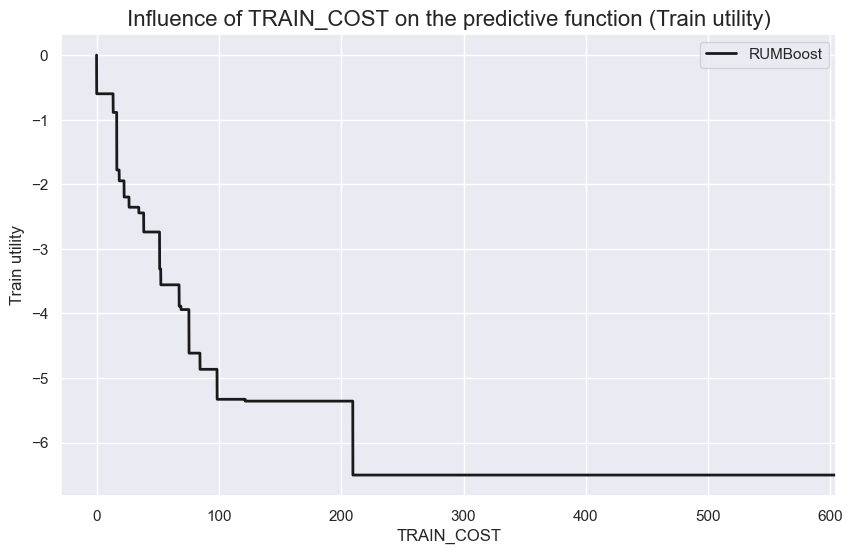

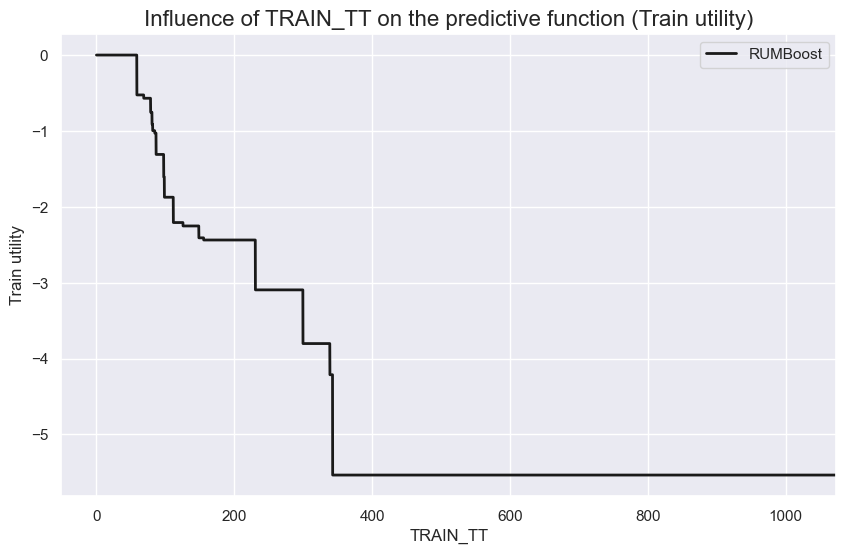

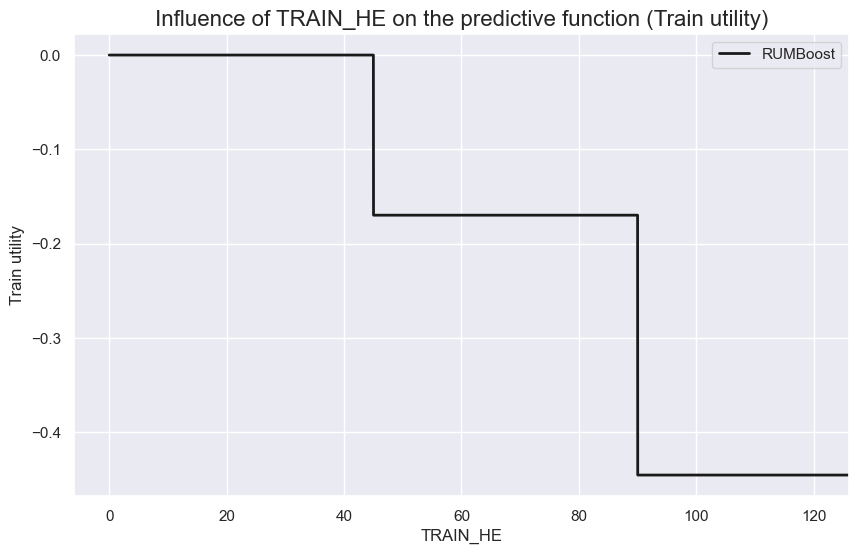

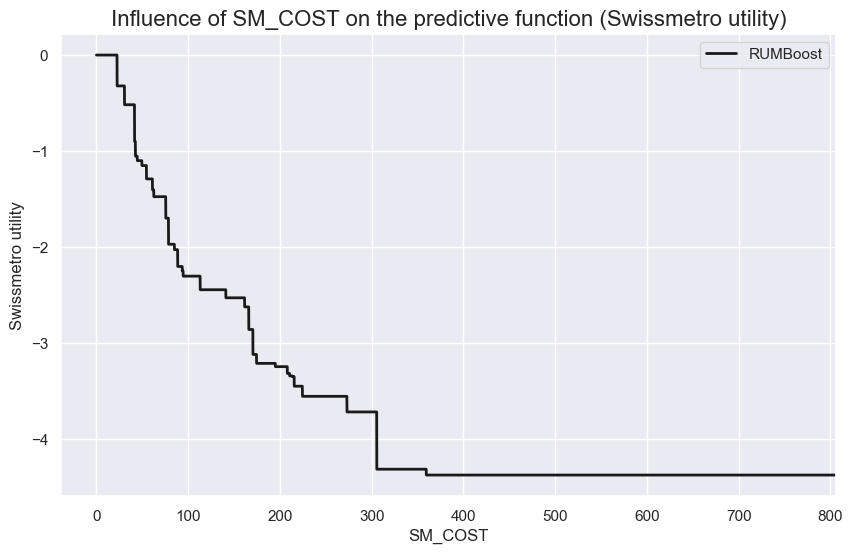

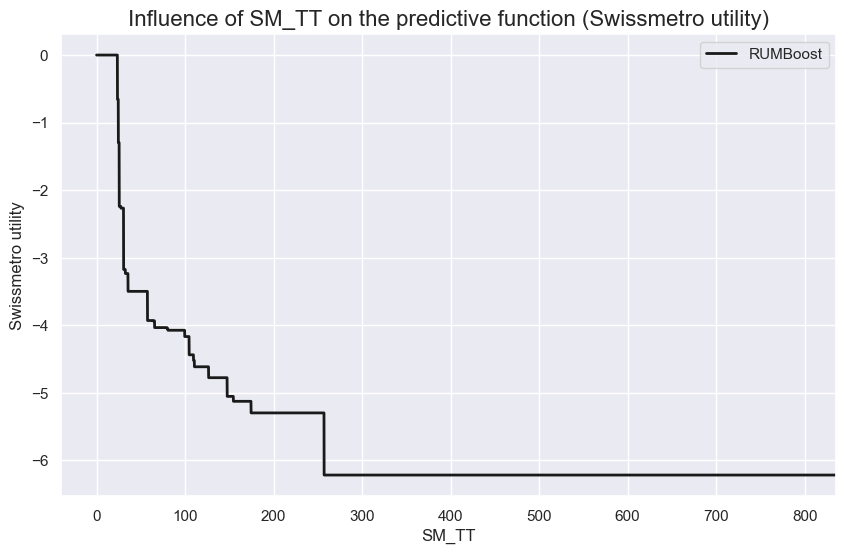

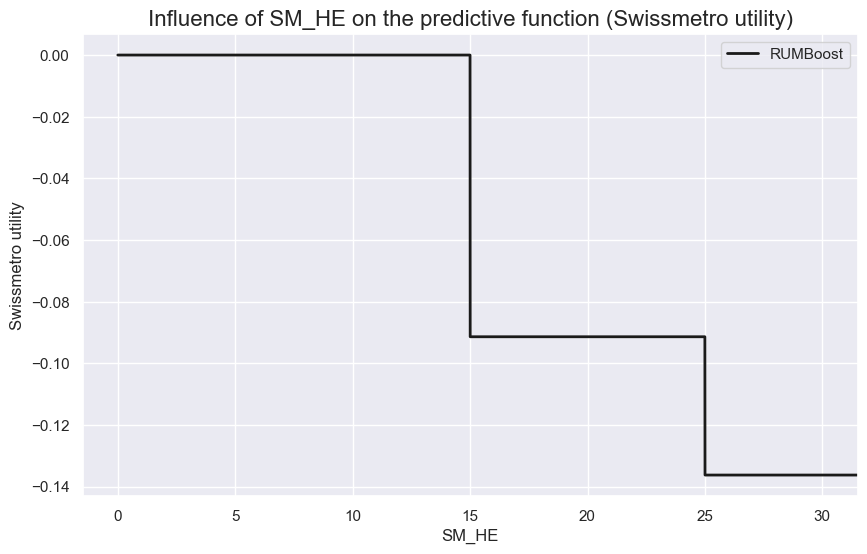

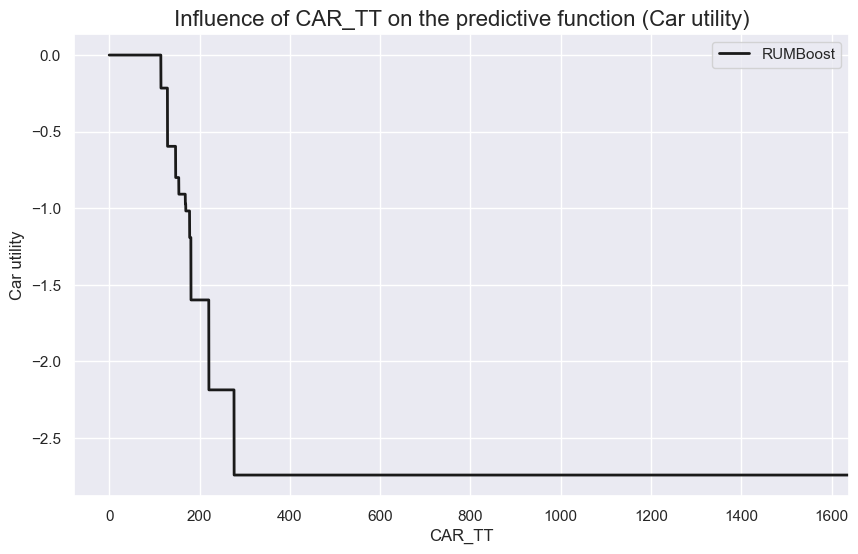

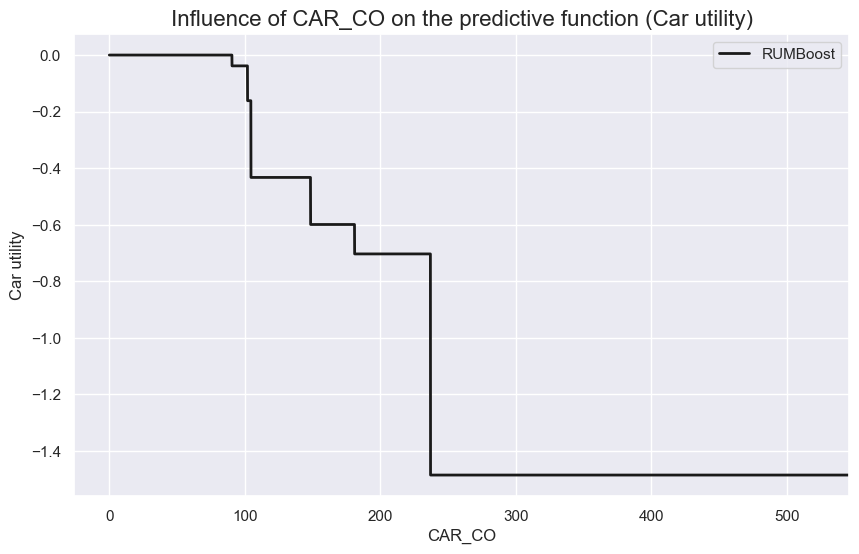

In [7]:
utility_names = {'0':'Train', '1':'Swissmetro', '2':'Car'}

plot_parameters(trained_model, swissmetro_train, utility_names, asc_normalised=True, only_1d=True)

## Function smoothing

Also there are a few techniques that are available in the rumboost package to smooth the utility output, I will only present splines, the one that showed the most promising output. There are three attribute selection techniques and two data points sampling methods to find the best number of splines. I will use the best one only (utility importance with linearly spaced sampling).

In [8]:
#find best number of splines
weights = weights_to_plot_v2(trained_model)
spline_utilities = {'0':['TRAIN_TT', 'TRAIN_COST'], '1':['SM_TT', 'SM_COST'], '2': ['CAR_TT', 'CAR_CO']}
best_splines, _ = find_best_num_splines(weights, swissmetro_train, swissmetro_test, swissmetro_test['CHOICE'], spline_utilities, search_technique='greedy_ranked')

{'0': {'TRAIN_COST': 3}}
CE = 0.8080452087022905 at iteration 1 for feature TRAIN_COST ---- best CE = 0.8080452087022905 with best knots: {'0': {'TRAIN_COST': 3}}
{'0': {'TRAIN_COST': 4}}
CE = 0.7641821714448073 at iteration 2 for feature TRAIN_COST ---- best CE = 0.7641821714448073 with best knots: {'0': {'TRAIN_COST': 4}}
{'0': {'TRAIN_COST': 5}}
CE = 0.7553322795289137 at iteration 3 for feature TRAIN_COST ---- best CE = 0.7553322795289137 with best knots: {'0': {'TRAIN_COST': 5}}
{'0': {'TRAIN_COST': 6}}
CE = 0.7599091103940594 at iteration 4 for feature TRAIN_COST ---- best CE = 0.7553322795289137 with best knots: {'0': {'TRAIN_COST': 5}}
{'0': {'TRAIN_COST': 7}}
CE = 0.7593417721640559 at iteration 5 for feature TRAIN_COST ---- best CE = 0.7553322795289137 with best knots: {'0': {'TRAIN_COST': 5}}
{'0': {'TRAIN_COST': 8}}
CE = 0.7552748081413361 at iteration 6 for feature TRAIN_COST ---- best CE = 0.7552748081413361 with best knots: {'0': {'TRAIN_COST': 8}}
{'0': {'TRAIN_COST': 9

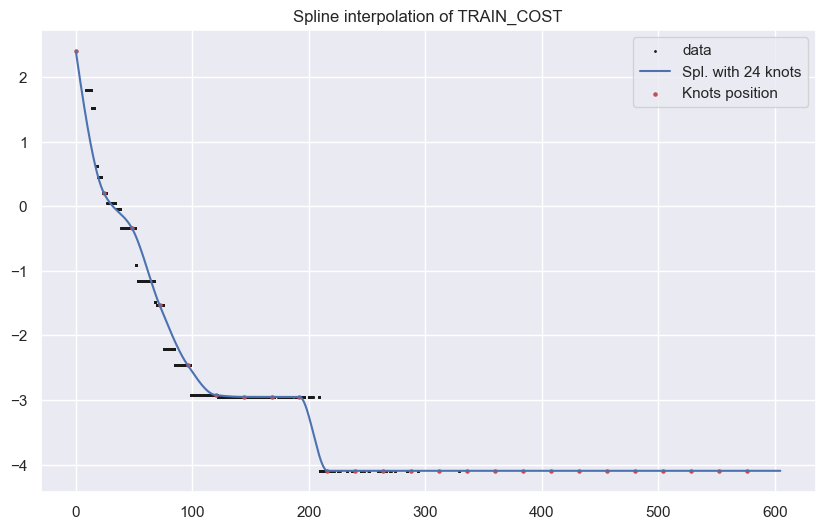

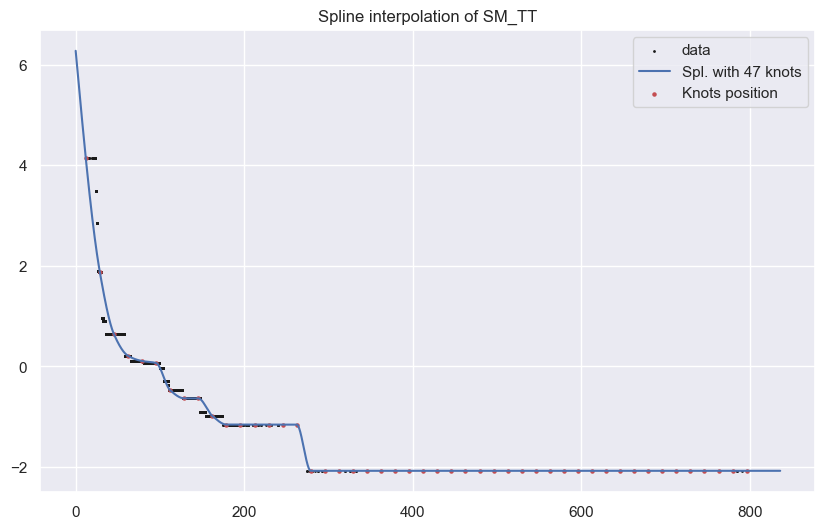

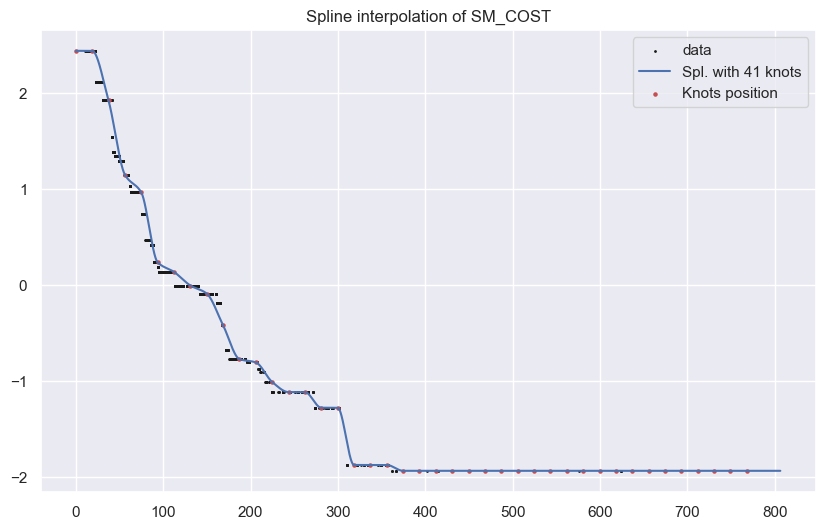

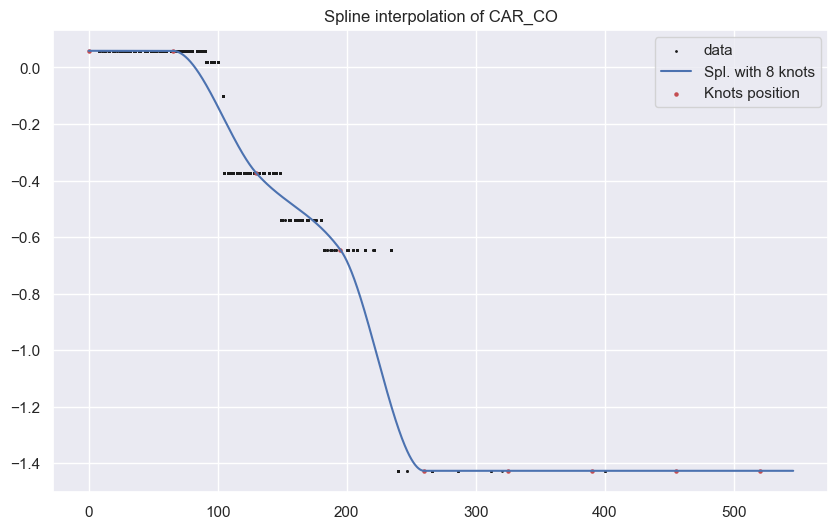

In [9]:
plot_spline(trained_model, swissmetro_train, best_splines)

# Example 2: LPMC

In [4]:
#load dataset
LPMC_train, LPMC_test, folds = load_preprocess_LPMC()

#load model
LPMC_model = LPMC(LPMC_train)

## Training a RUMBoost model

In [5]:
#parameters
params = {'n_jobs': -1,
          'num_classes':4,
          'objective':'multiclass',
          'boosting': 'gbdt',
          'monotone_constraints_method': 'advanced',
          'verbosity': -1,
          'num_iterations':1500,
          'early_stopping_round':100,
          'learning_rate':0.1
          }

#features and label column names

features = [f for f in LPMC_train.columns if f != "choice"]

label = "choice"
#create lightgbm dataset
dataset_train = lightgbm.Dataset(LPMC_train[features], label=LPMC_train[label], free_raw_data=False)
dataset_test = lightgbm.Dataset(LPMC_test[features], label=LPMC_test[label], free_raw_data=False)

### Training with an MNL model

In [6]:
rum_structure = bio_to_rumboost(LPMC_model)

LPMC_model_trained = rum_cv(params,dataset_train,folds=folds, rum_structure=rum_structure)

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\rumboost\rumboost.py:1204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: User

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

## Plotting with a rum_structure dictionary


In [13]:
rum_structure = bio_to_rumboost(LPMC_model)
rum_structure

[{'columns': ['age',
   'female',
   'day_of_week',
   'start_time_linear',
   'car_ownership',
   'driving_license',
   'purpose_B',
   'purpose_HBE',
   'purpose_HBO',
   'purpose_HBW',
   'purpose_NHBO',
   'fueltype_Average',
   'fueltype_Diesel',
   'fueltype_Hybrid',
   'fueltype_Petrol',
   'distance',
   'dur_walking'],
  'monotone_constraints': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   -1,
   -1],
  'interaction_constraints': [[0],
   [1],
   [2],
   [3],
   [4],
   [5],
   [6],
   [7],
   [8],
   [9],
   [10],
   [11],
   [12],
   [13],
   [14],
   [15],
   [16]],
  'betas': ['B_age_Walk',
   'B_female_Walk',
   'B_day_of_week_Walk',
   'B_start_time_linear_Walk',
   'B_car_ownership_Walk',
   'B_driving_license_Walk',
   'B_purpose_B_Walk',
   'B_purpose_HBE_Walk',
   'B_purpose_HBO_Walk',
   'B_purpose_HBW_Walk',
   'B_purpose_NHBO_Walk',
   'B_fueltype_Avrg_Walk',
   'B_fueltype_Diesel_Walk',
   'B_fueltype_Hybrid_Walk',
   

In [14]:
LPMC_model_trained = rum_train(params,dataset_train,rum_structure, valid_sets=[dataset_test])

c:\Users\DAF1\OneDrive - University College London\Documents\PhD - UCL\rumboost\rumboost\rumboost.py:715: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9584, number of negative: 45182
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 54766, number of used features: 17
[LightGBM] [Info] Number of positive: 1544, number of negative: 53222
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 54766, number of used features: 17
[LightGBM] [Info] Number of positive: 19104, number of negative: 35662
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of te

## Plotting utilities


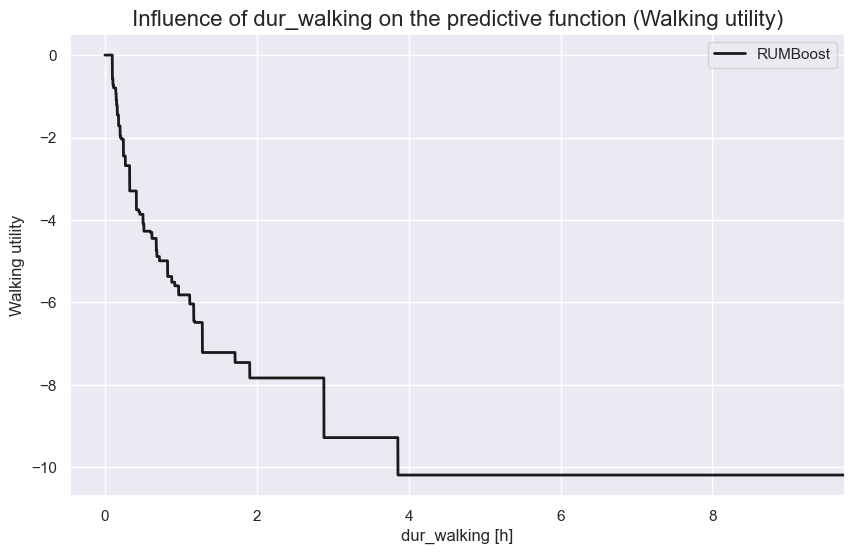

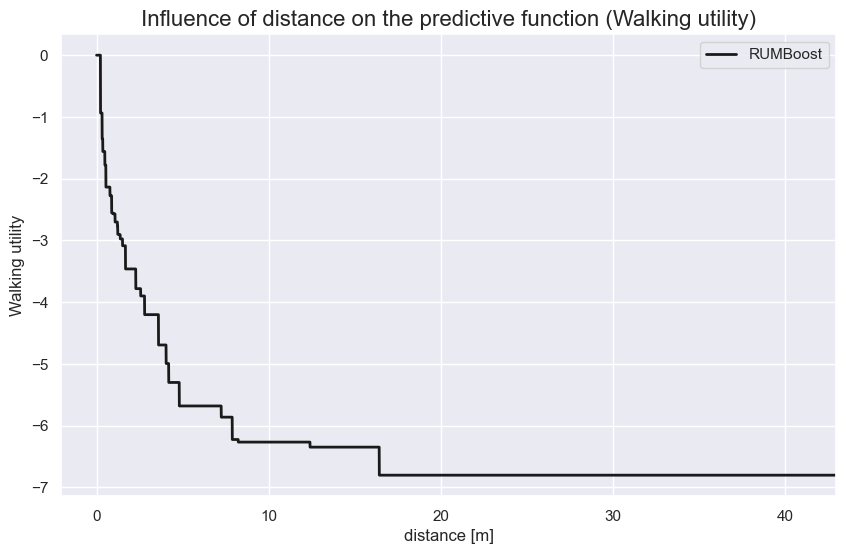

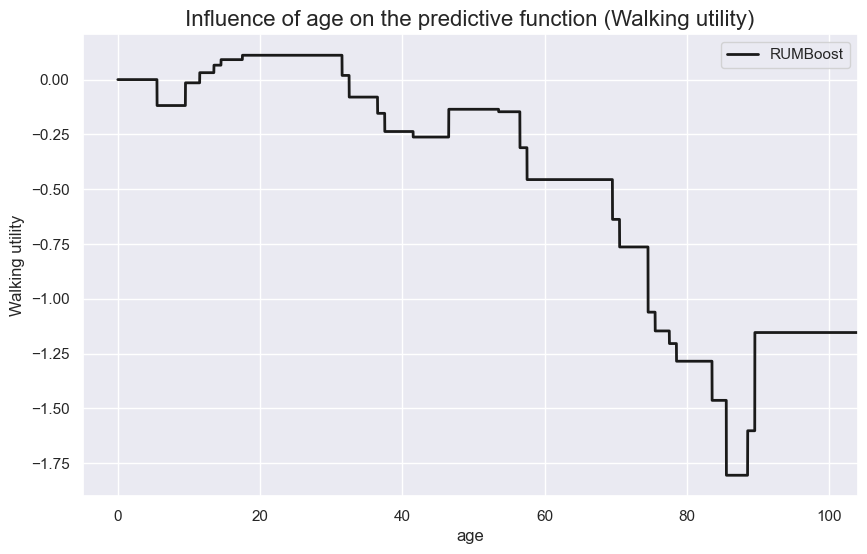

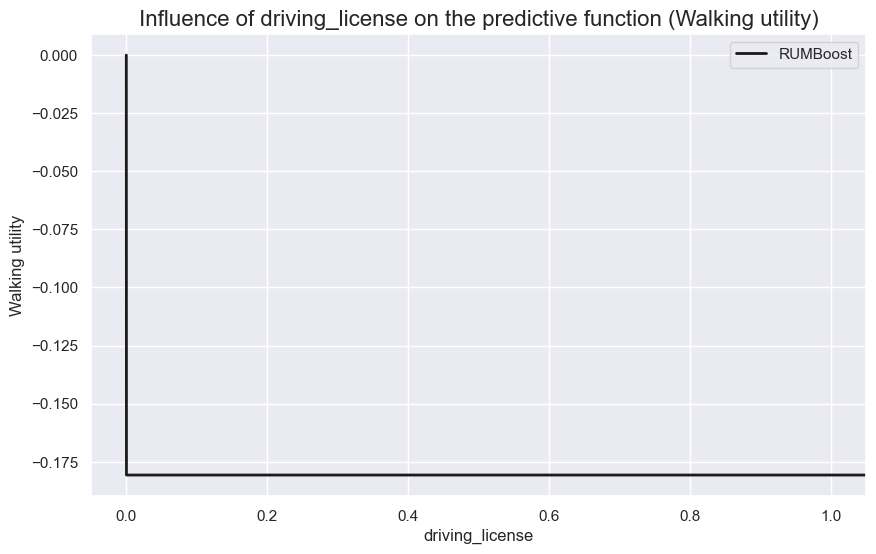

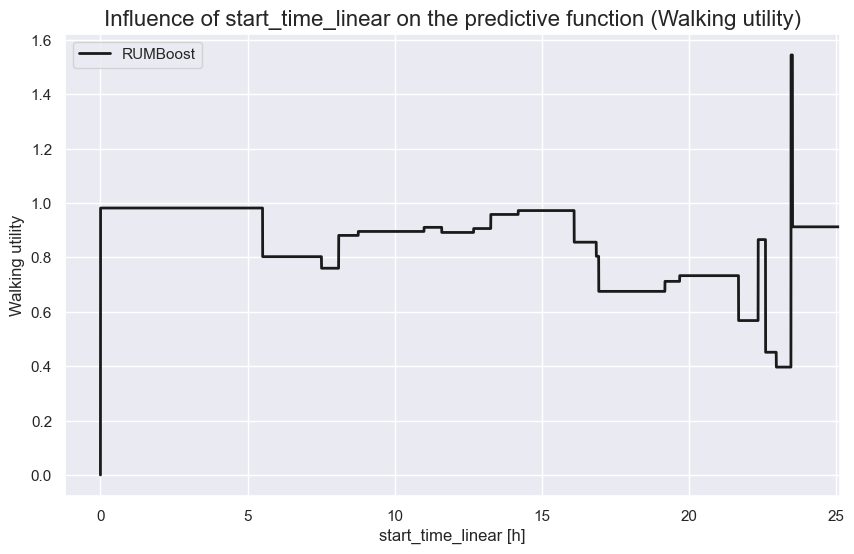

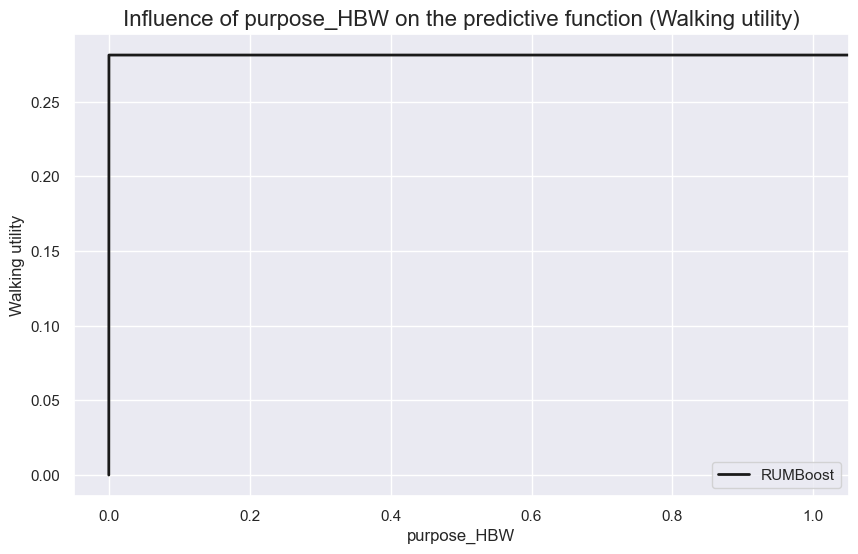

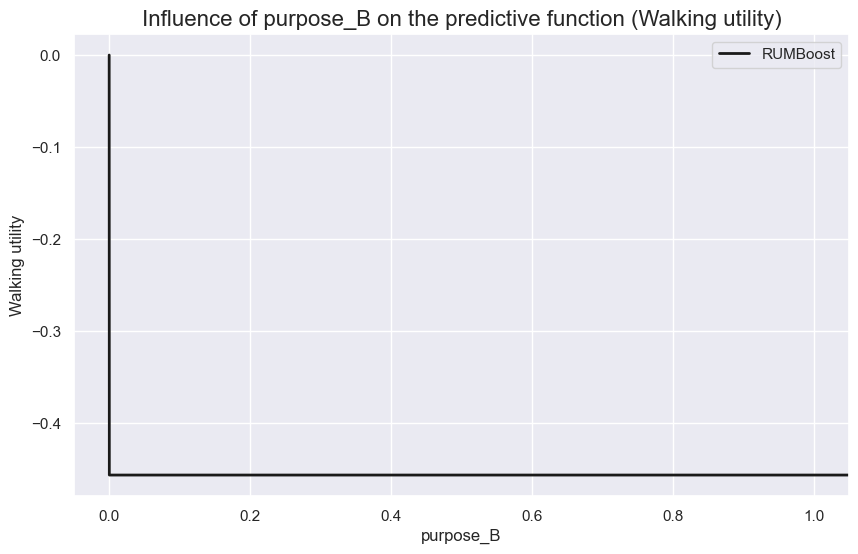

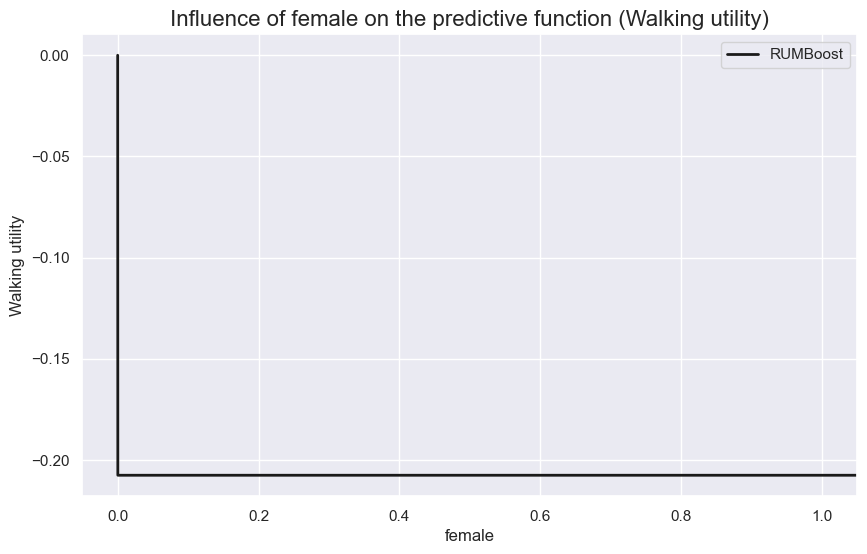

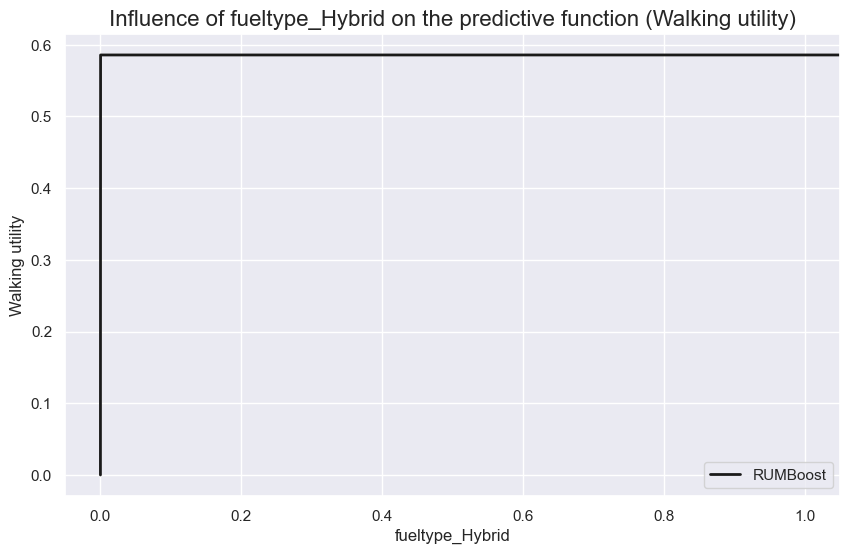

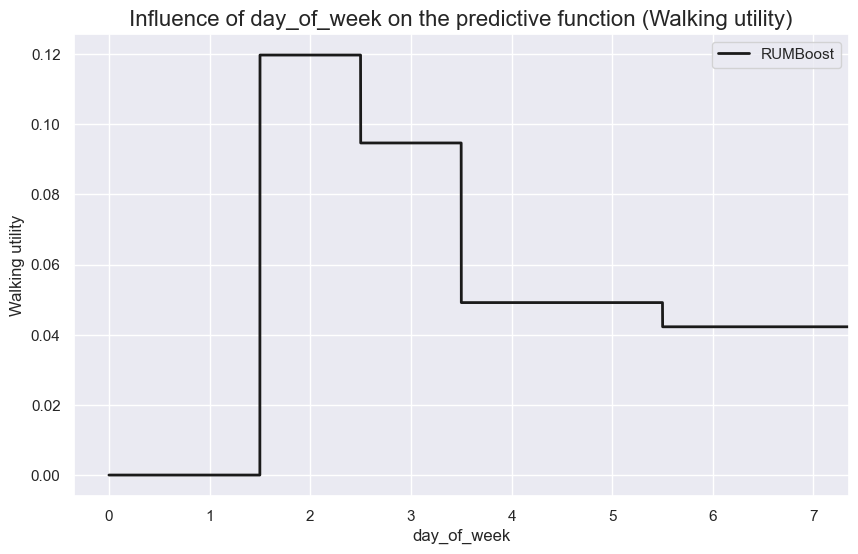

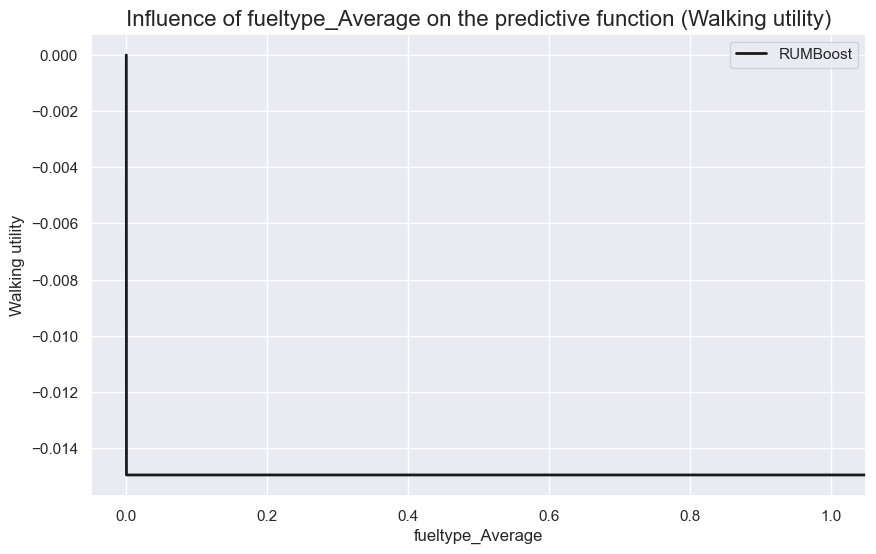

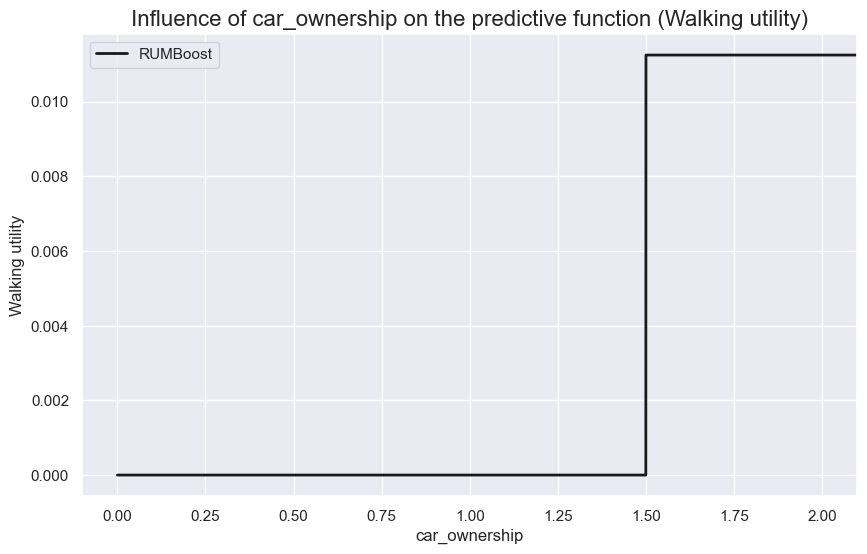

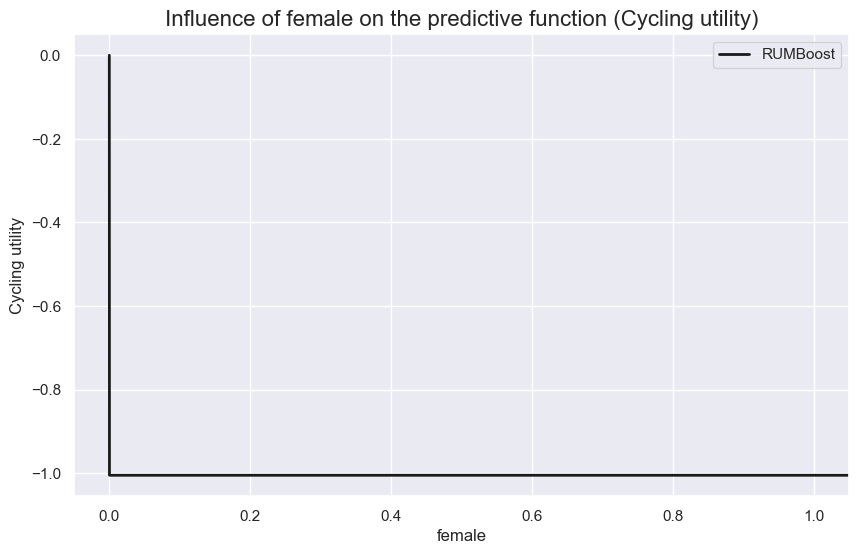

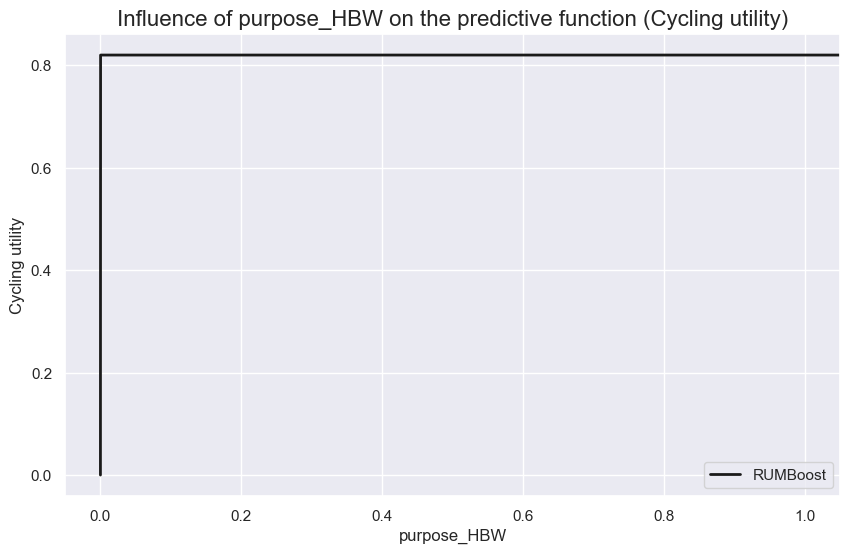

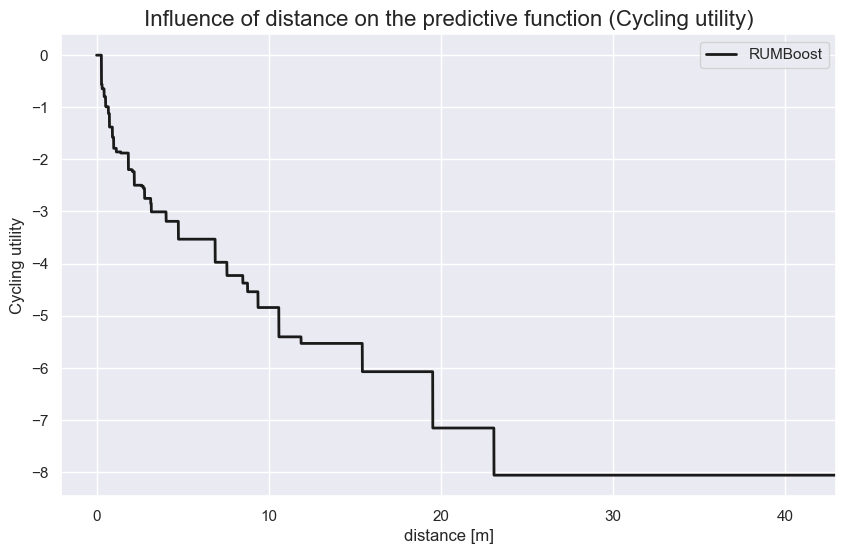

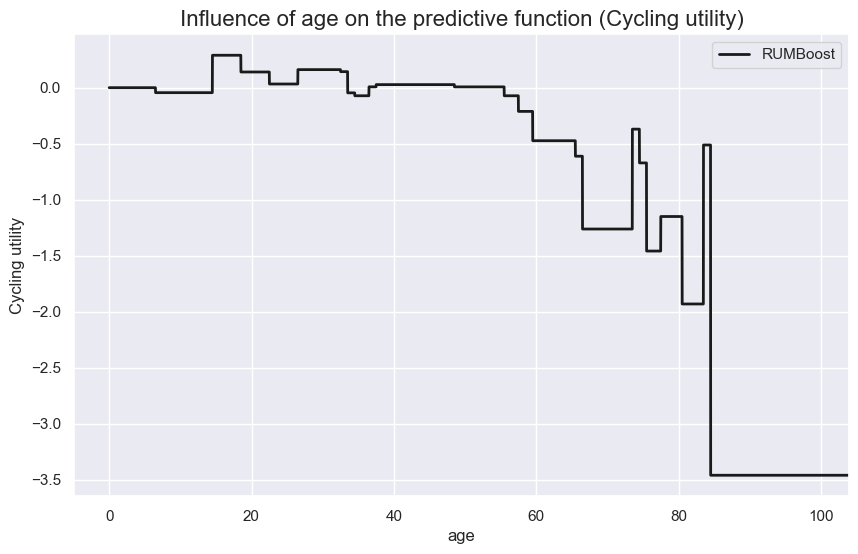

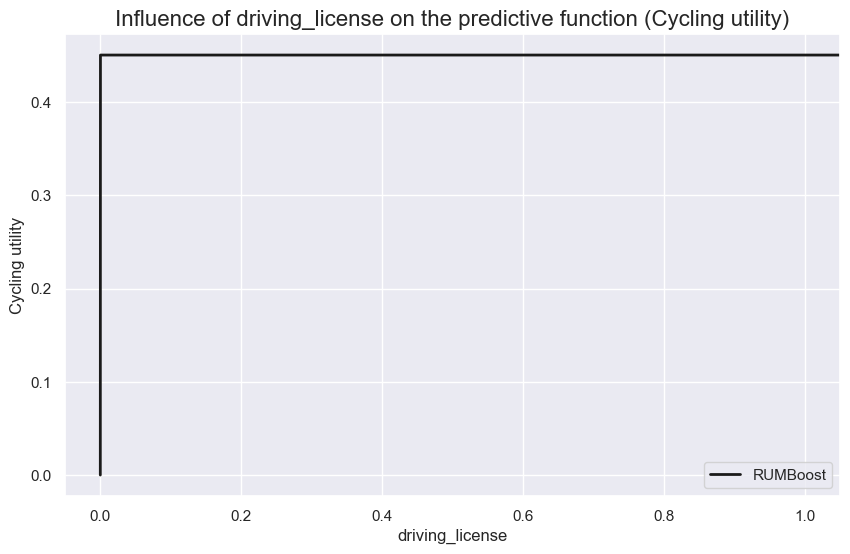

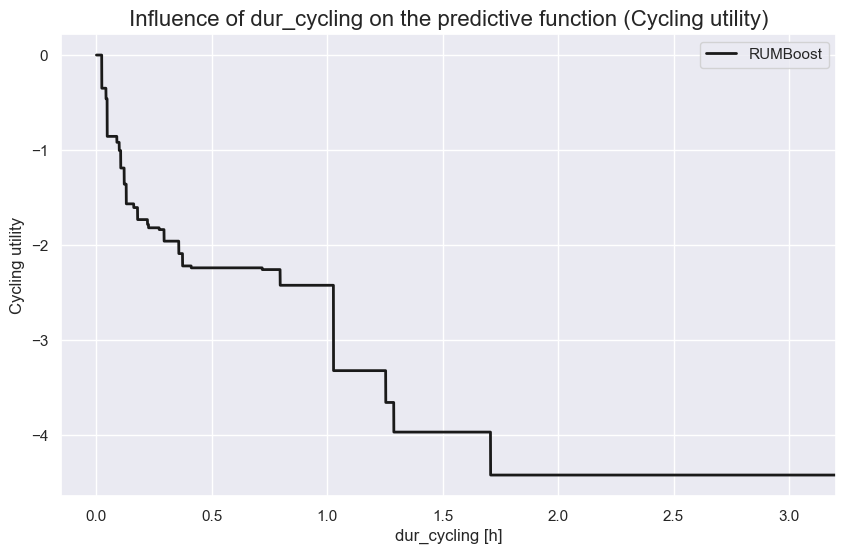

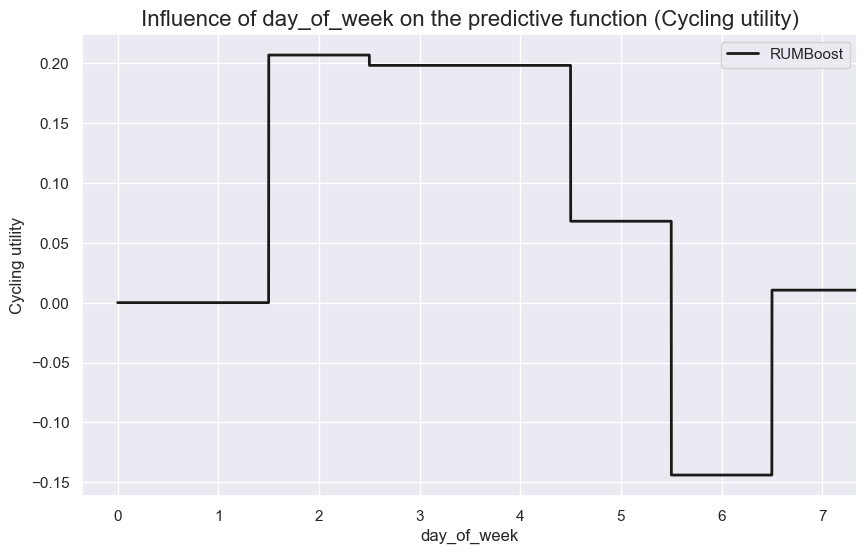

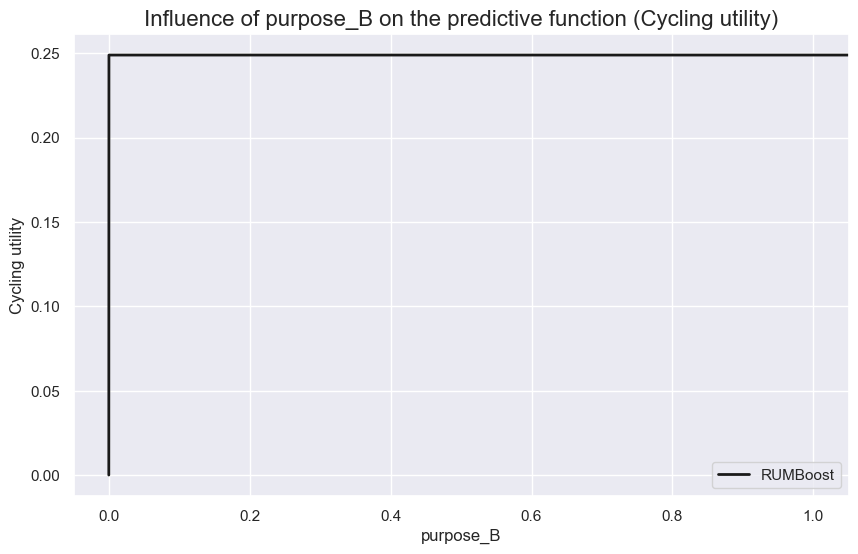

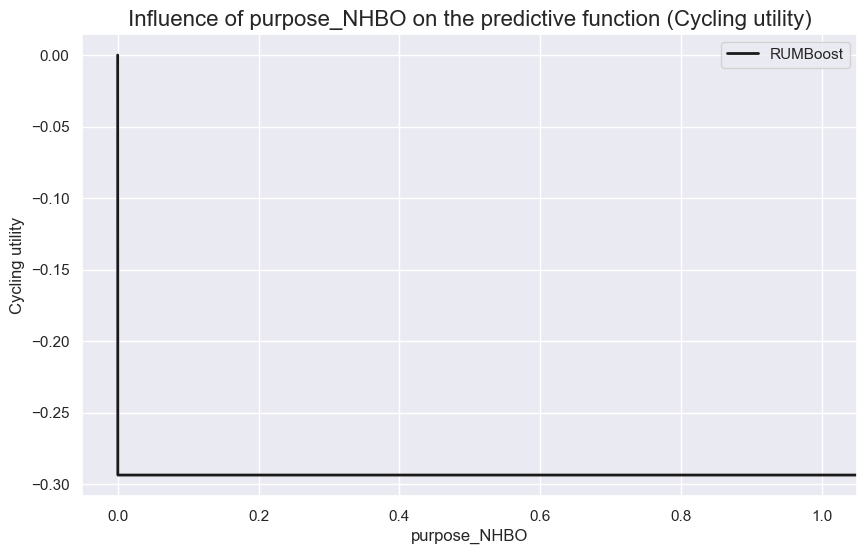

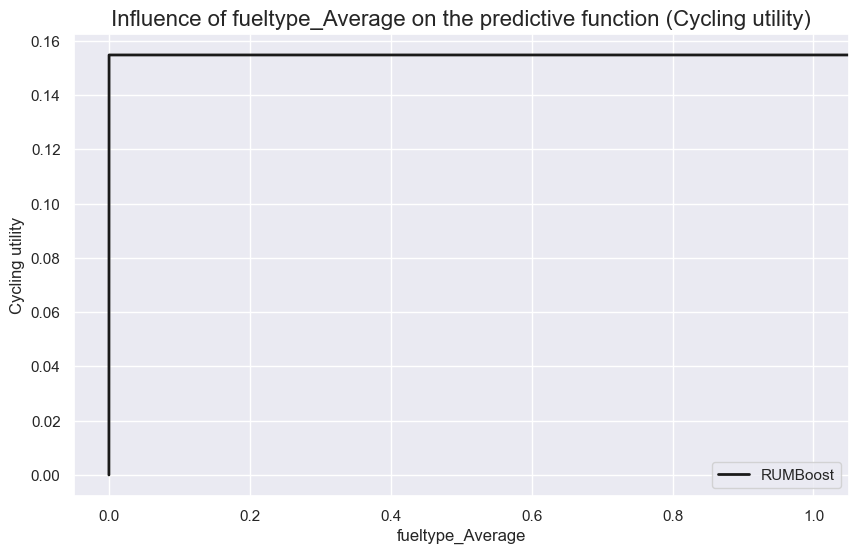

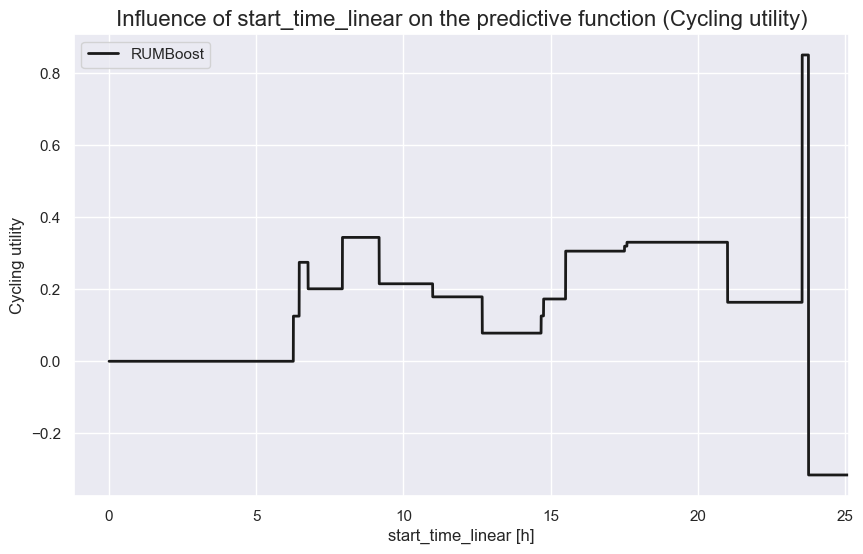

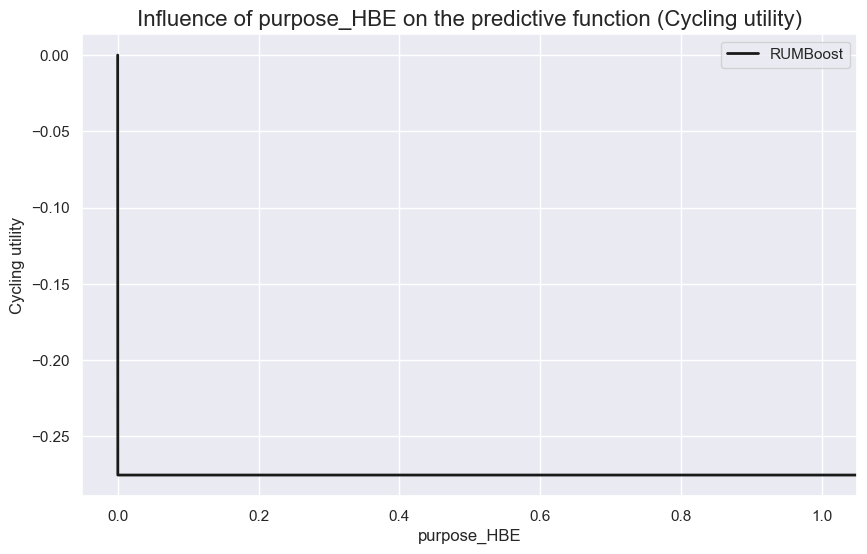

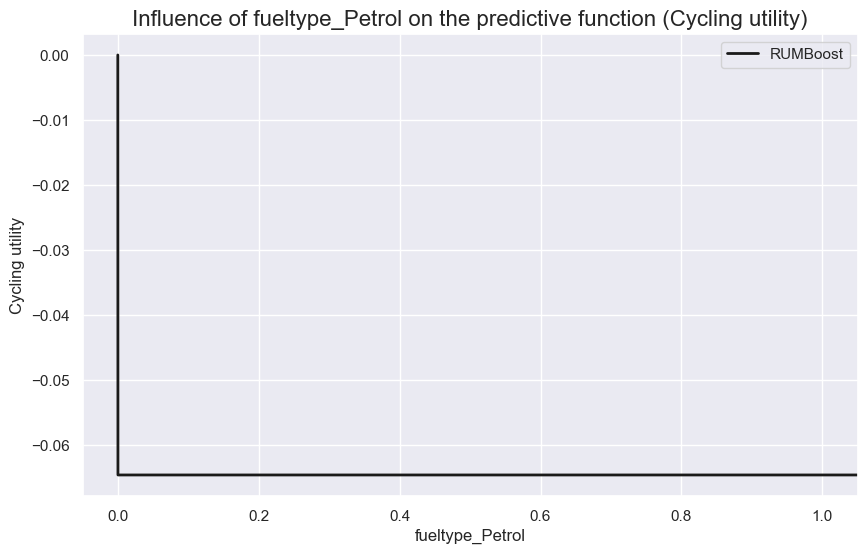

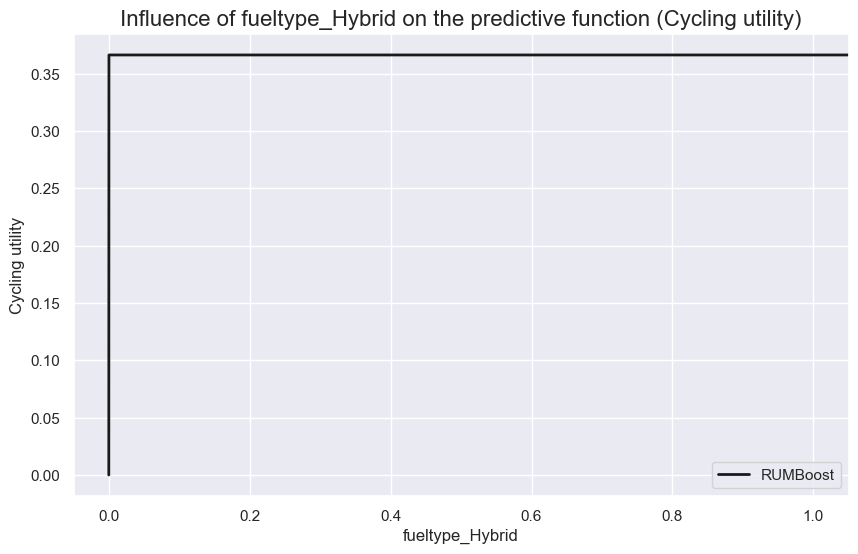

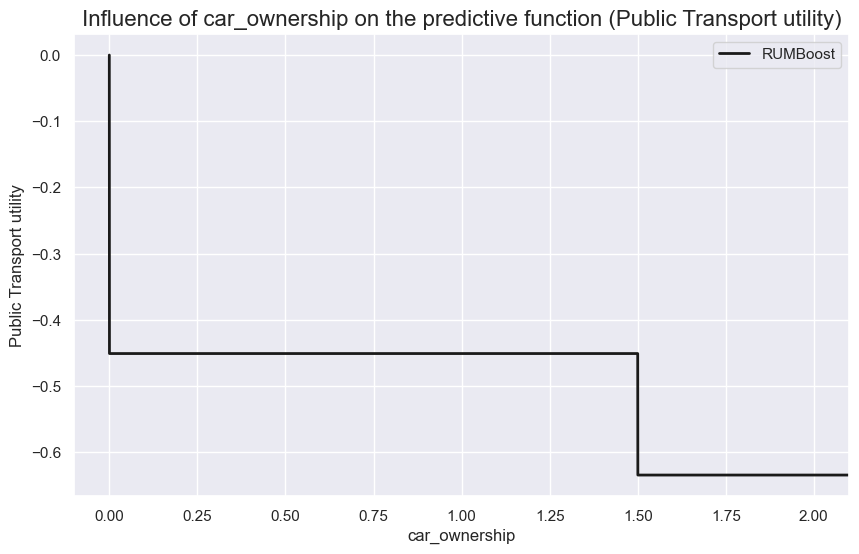

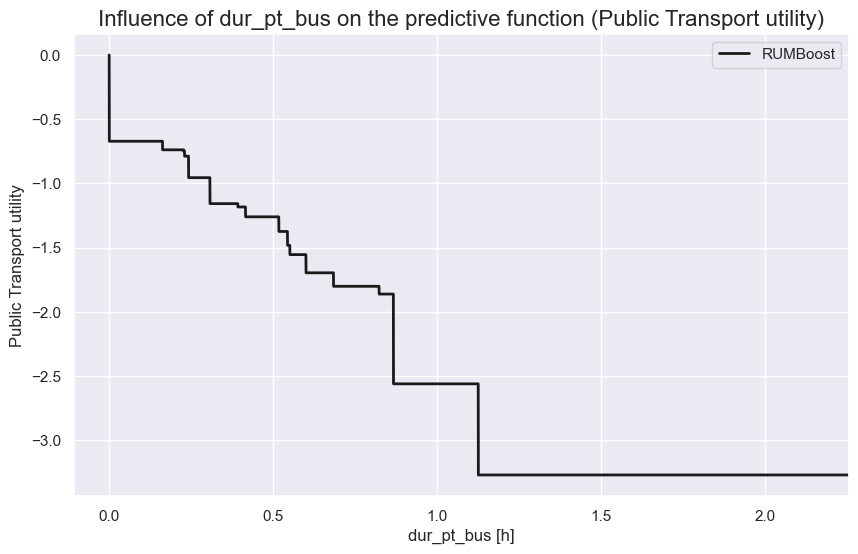

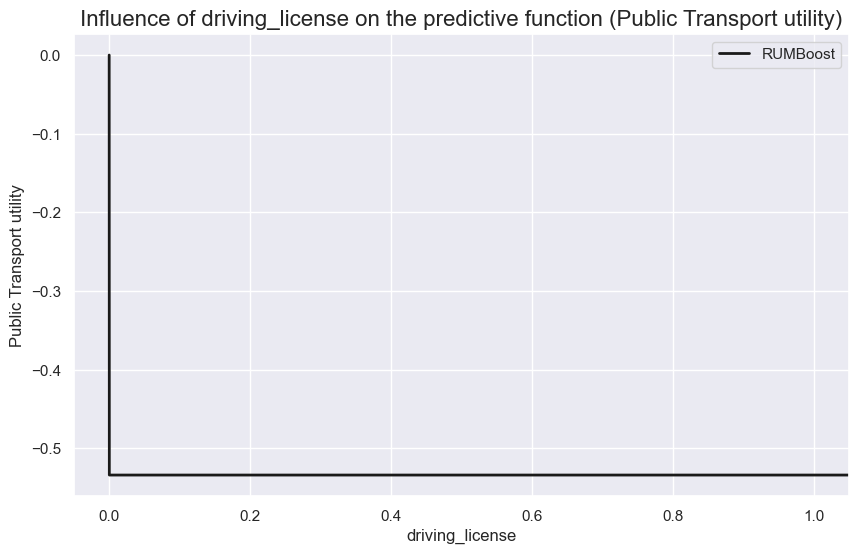

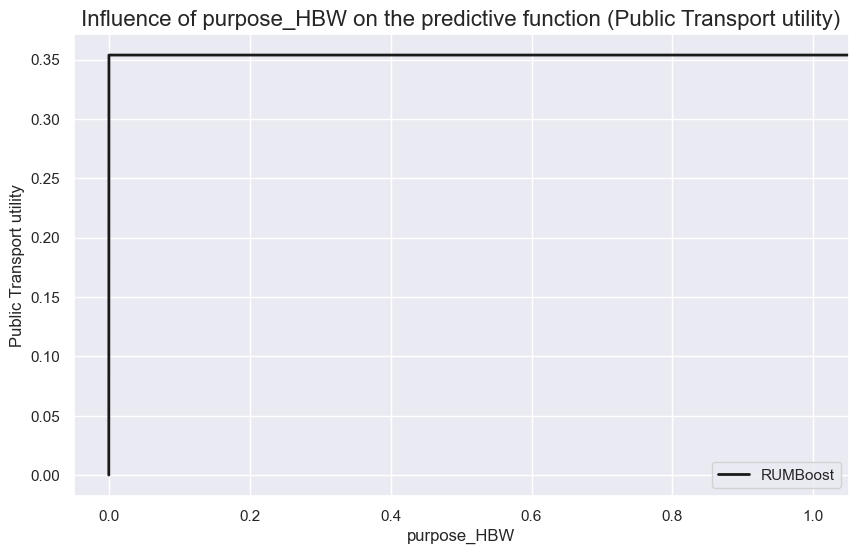

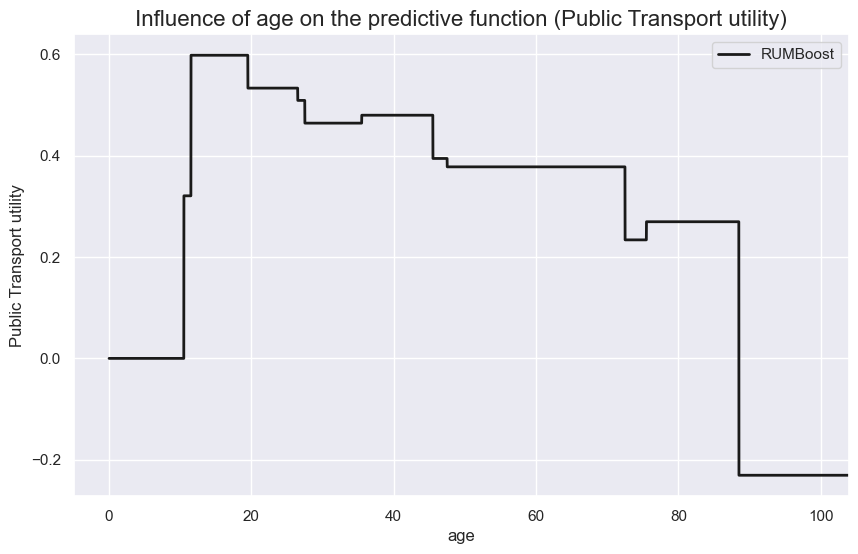

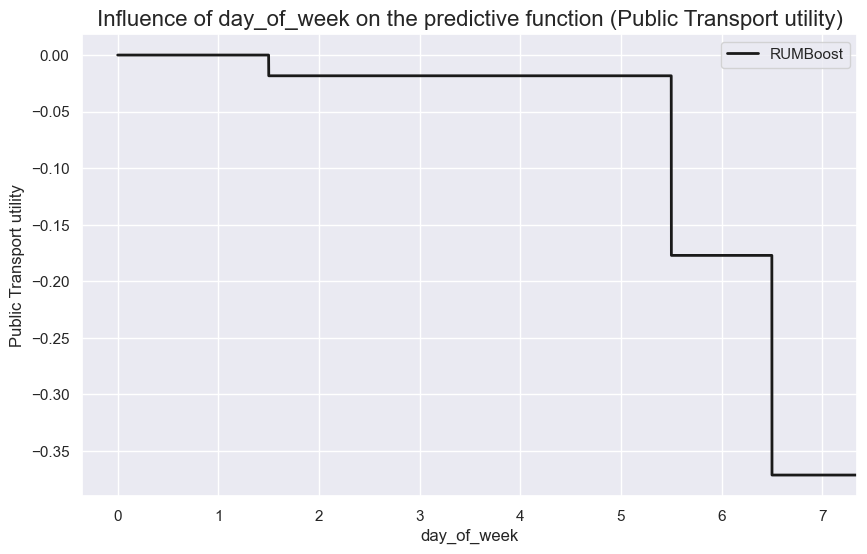

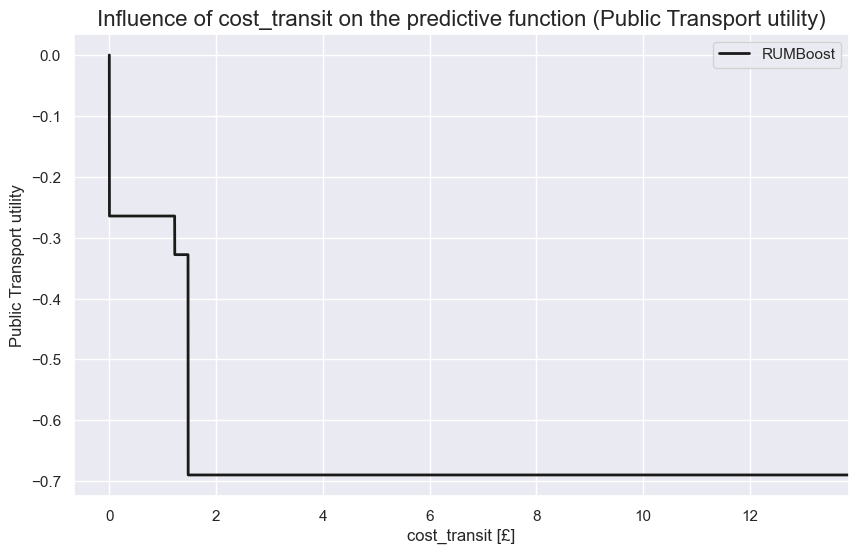

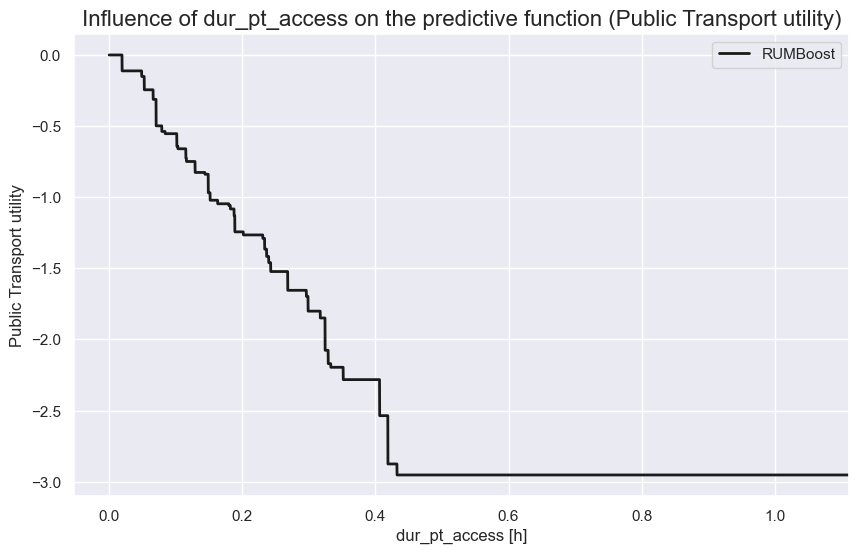

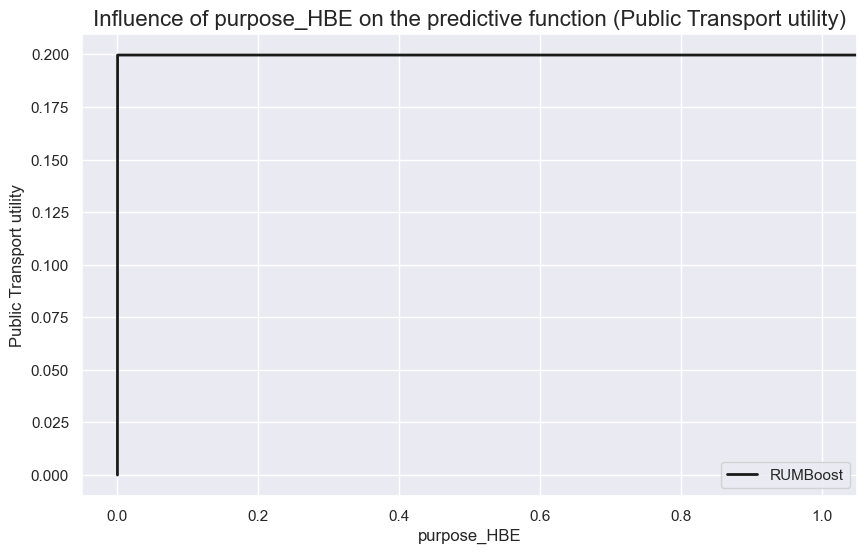

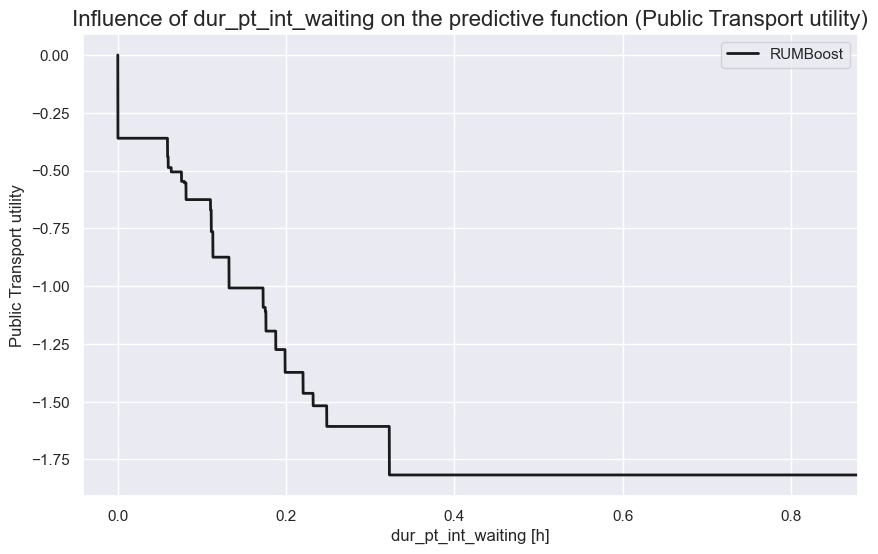

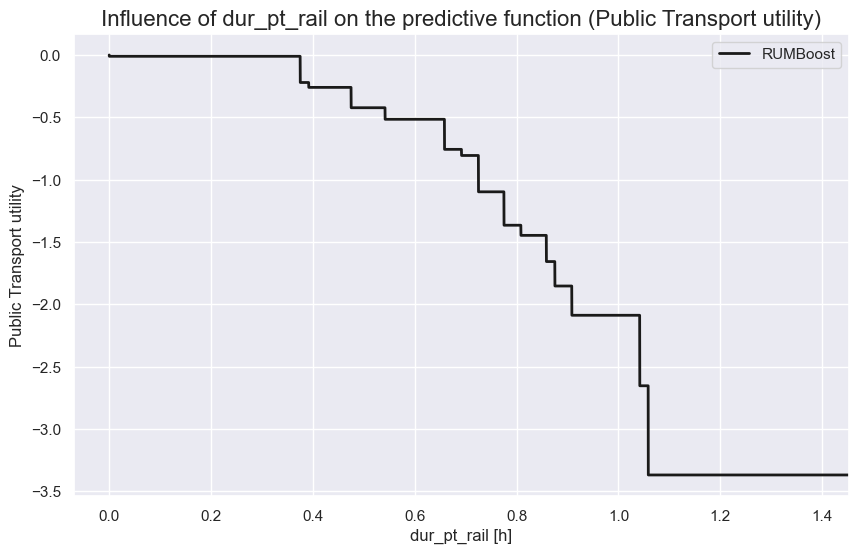

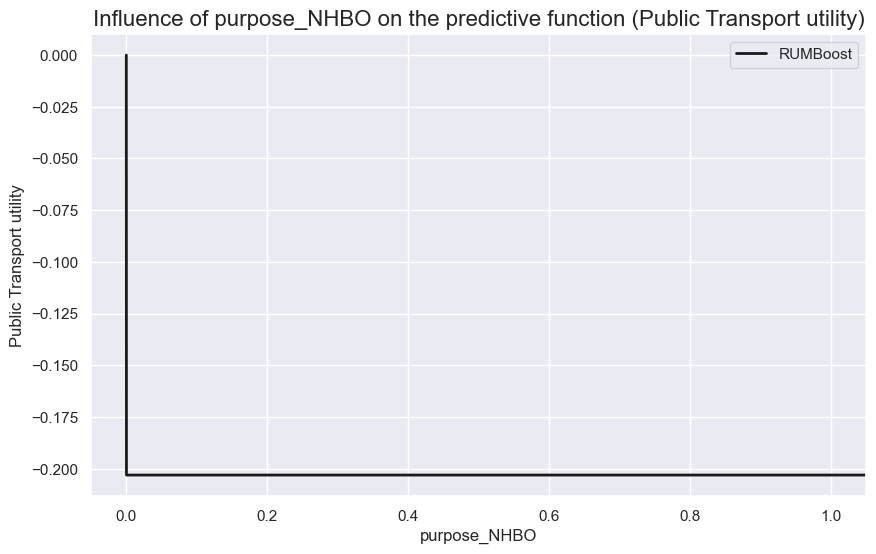

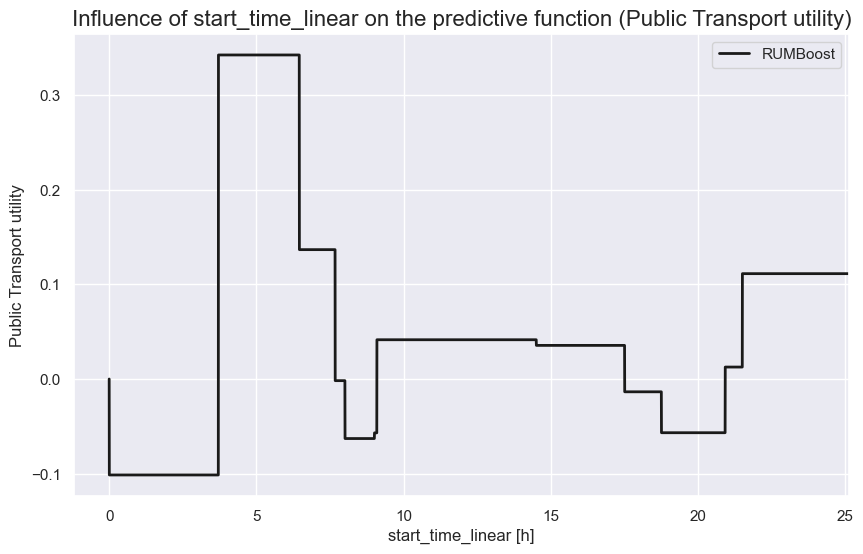

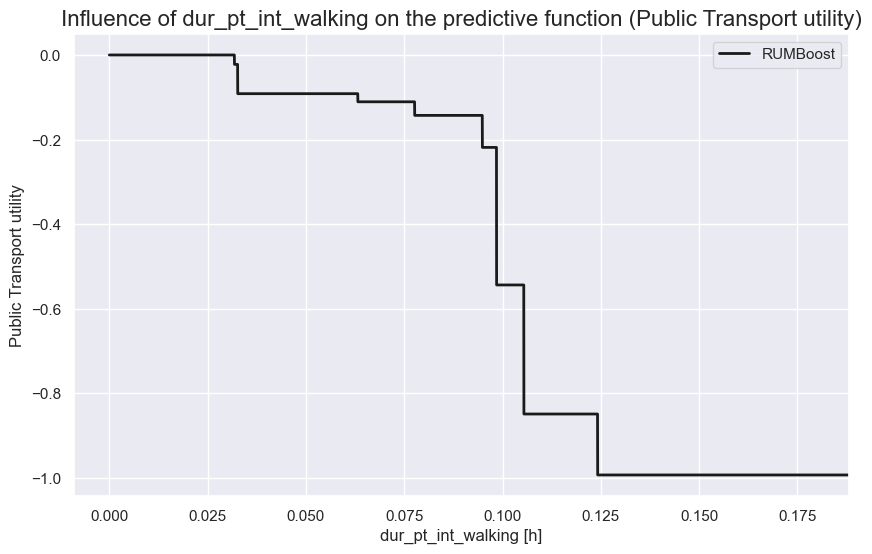

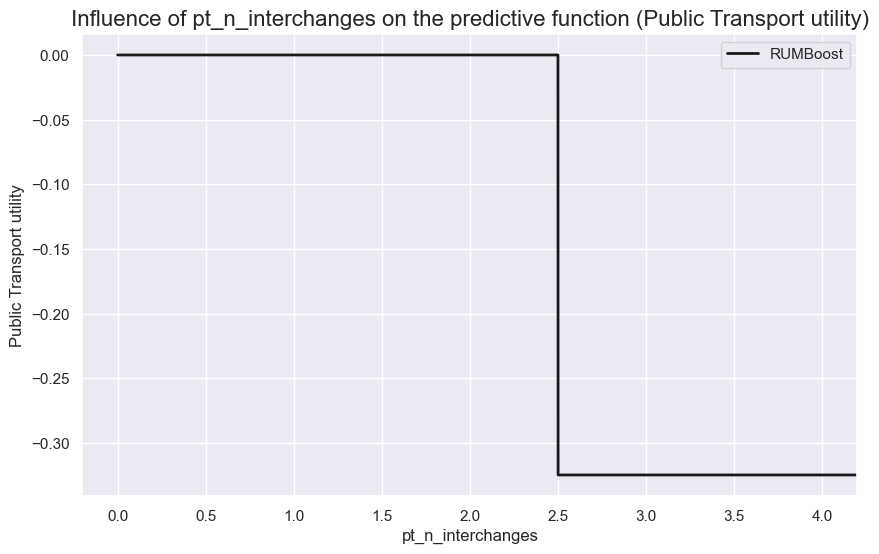

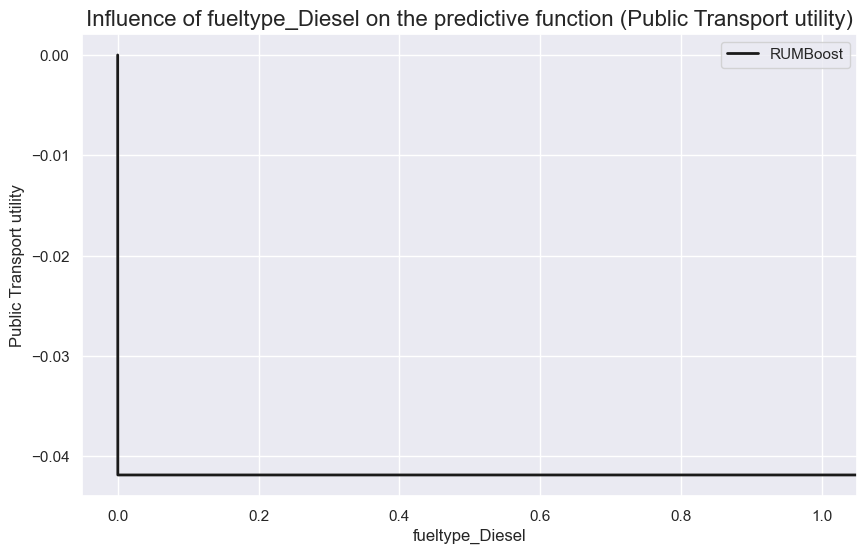

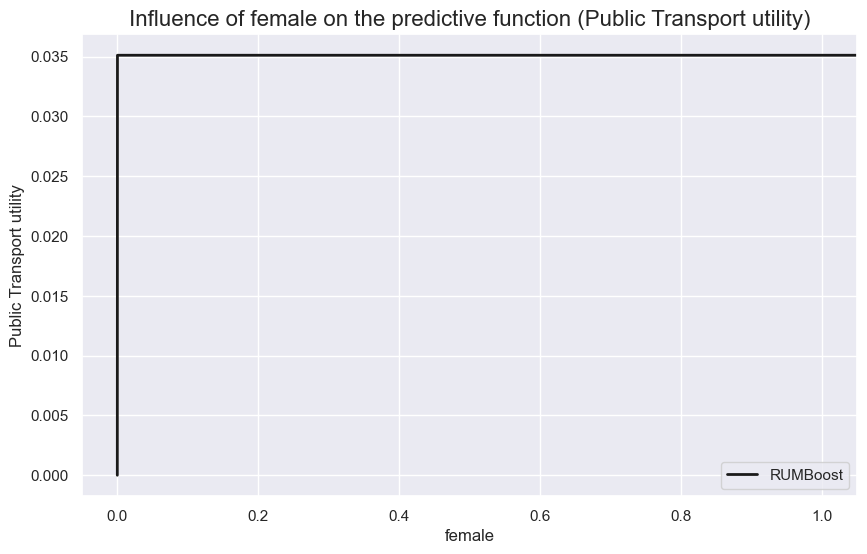

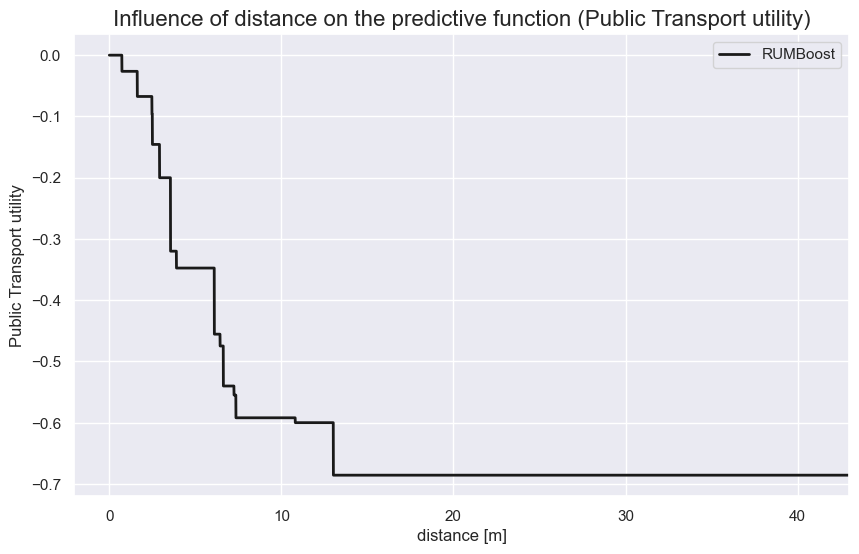

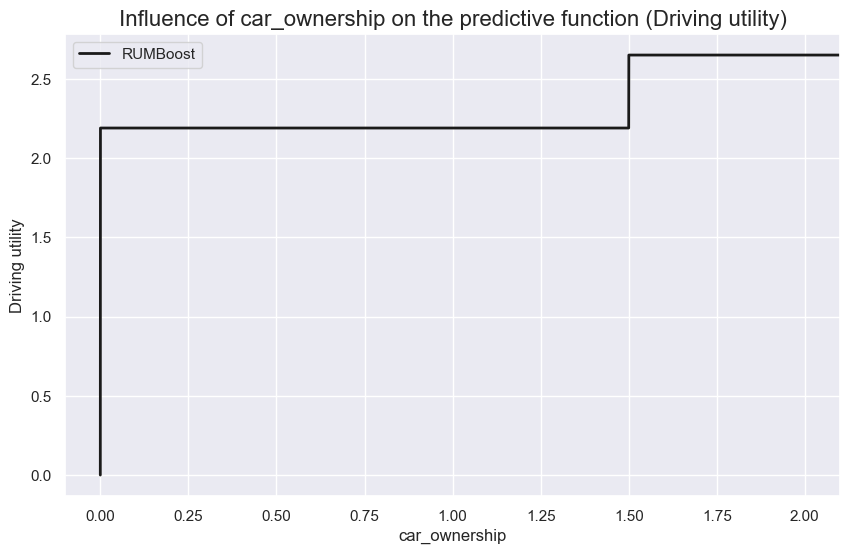

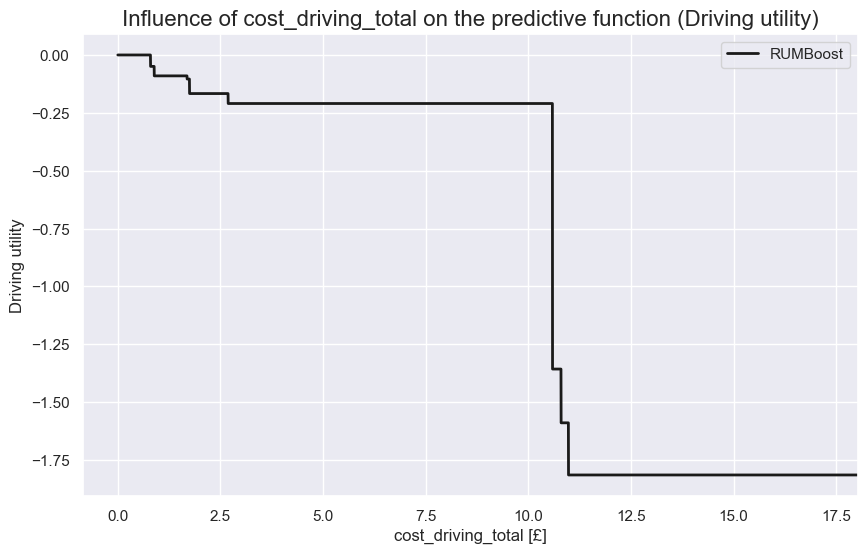

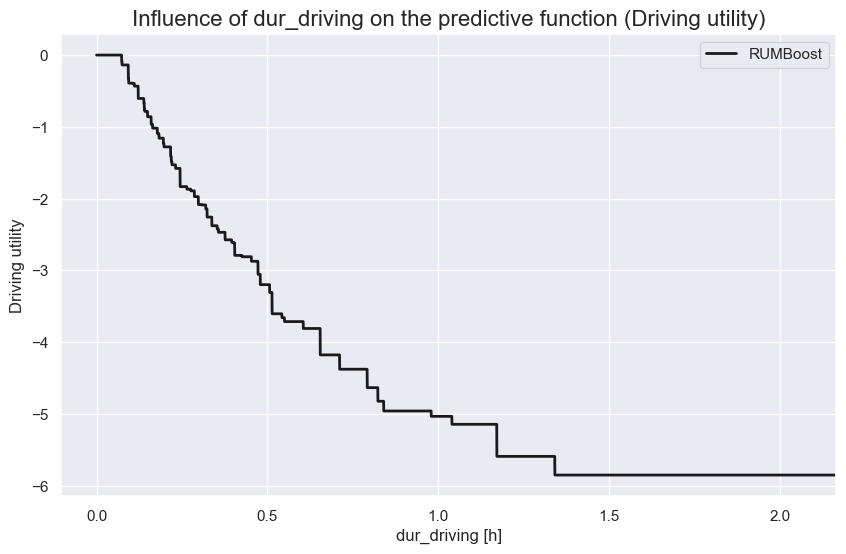

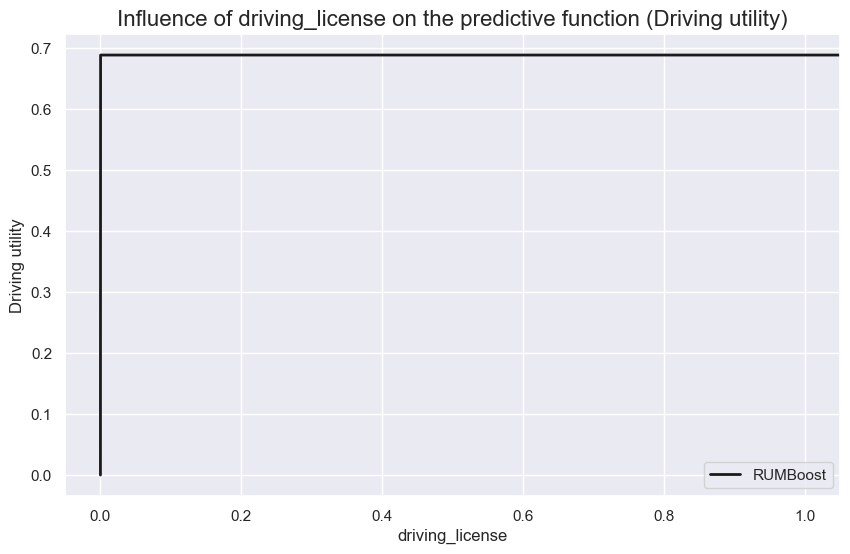

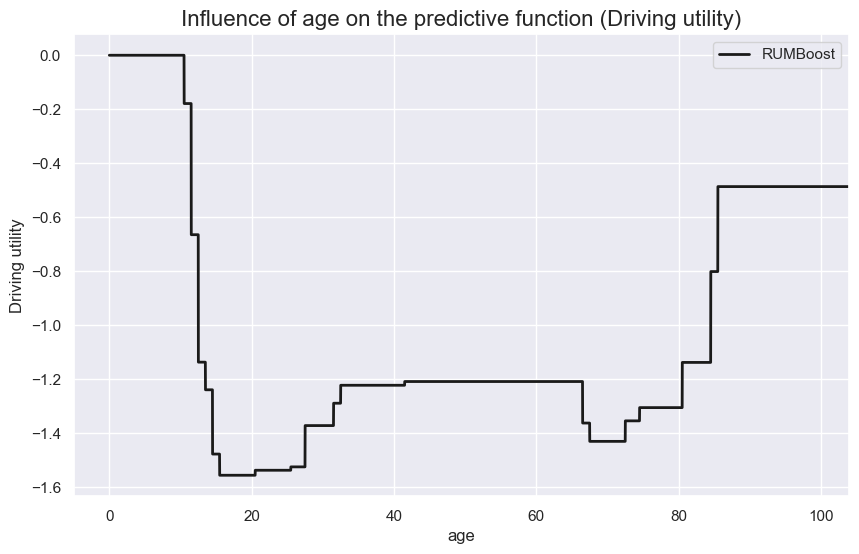

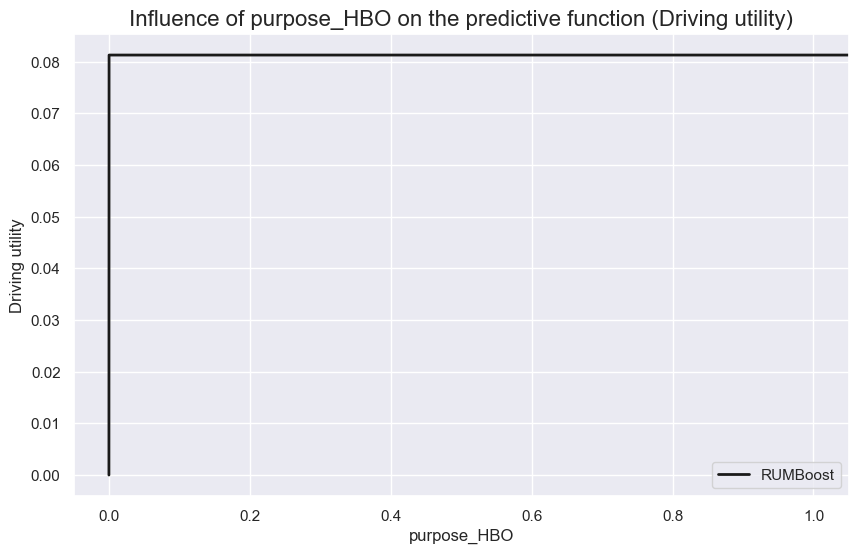

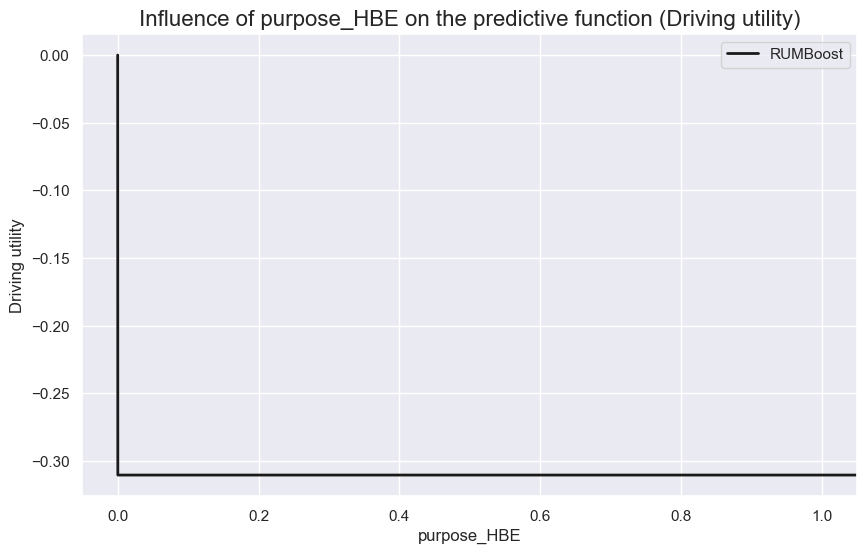

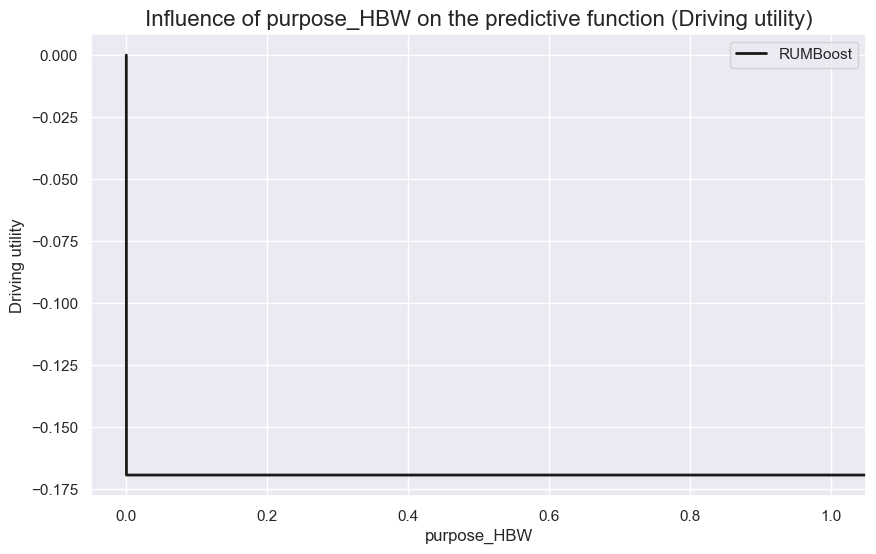

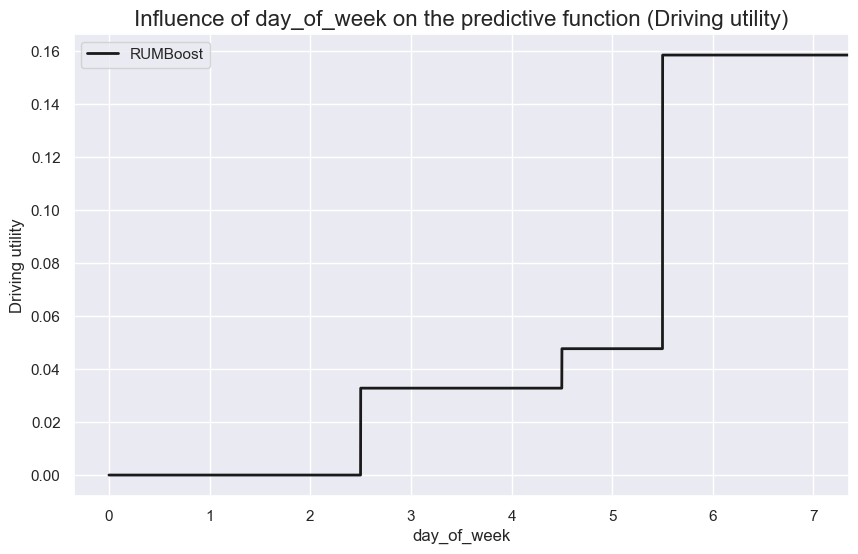

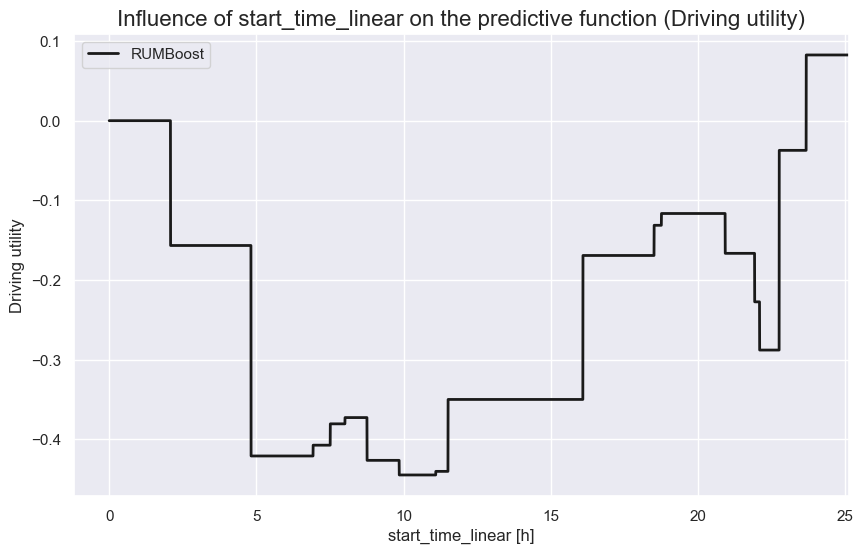

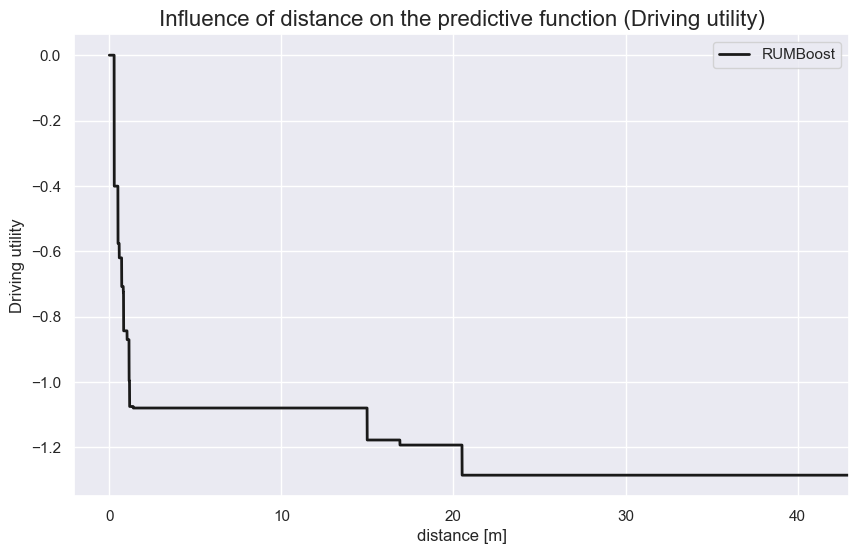

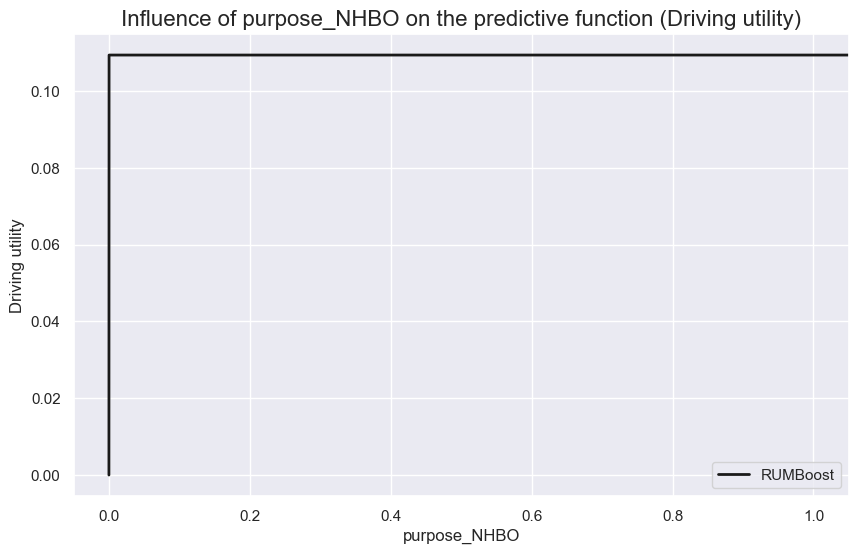

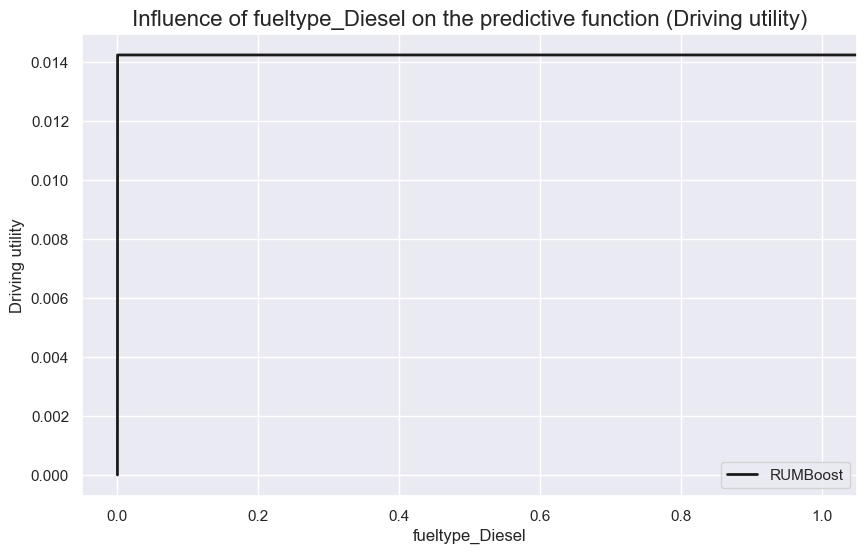

In [5]:
utility_names = {'0':'Walking', '1':'Cycling', '2':'Public Transport', '3': 'Driving'}

plot_parameters(LPMC_model_trained, LPMC_train, utility_names, asc_normalised=True, only_1d=True, save_figure=True)

## Function smoothing

In [17]:
#find best number of splines
weights = weights_to_plot_v2(LPMC_model_trained)
spline_utilities = {'0':['distance', 'dur_walking'],'1':['distance', 'dur_cycling'], '2':['distance', 'dur_pt_rail', 'dur_pt_bus', 'cost_transit', 'dur_pt_int_waiting', 'dur_pt_int_walking', 'dur_pt_access'], '3': ['distance', 'dur_driving','cost_driving_total']}
best_splines, _ = find_best_num_splines(weights, LPMC_train, LPMC_test, LPMC_test['choice'], spline_utilities, search_technique='greedy_ranked')

{'0': {'dur_walking': 3}}
CE = 0.7712990345670475 at iteration 1 for feature dur_walking ---- best CE = 0.7712990345670475 with best knots: {'0': {'dur_walking': 3}}
{'0': {'dur_walking': 4}}
CE = 0.7645620855682611 at iteration 2 for feature dur_walking ---- best CE = 0.7645620855682611 with best knots: {'0': {'dur_walking': 4}}
{'0': {'dur_walking': 5}}
CE = 0.7247320136764935 at iteration 3 for feature dur_walking ---- best CE = 0.7247320136764935 with best knots: {'0': {'dur_walking': 5}}
{'0': {'dur_walking': 6}}
CE = 0.7046405085843446 at iteration 4 for feature dur_walking ---- best CE = 0.7046405085843446 with best knots: {'0': {'dur_walking': 6}}
{'0': {'dur_walking': 7}}
CE = 0.683737649155987 at iteration 5 for feature dur_walking ---- best CE = 0.683737649155987 with best knots: {'0': {'dur_walking': 7}}
{'0': {'dur_walking': 8}}
CE = 0.6851217219451348 at iteration 6 for feature dur_walking ---- best CE = 0.683737649155987 with best knots: {'0': {'dur_walking': 7}}
{'0': {

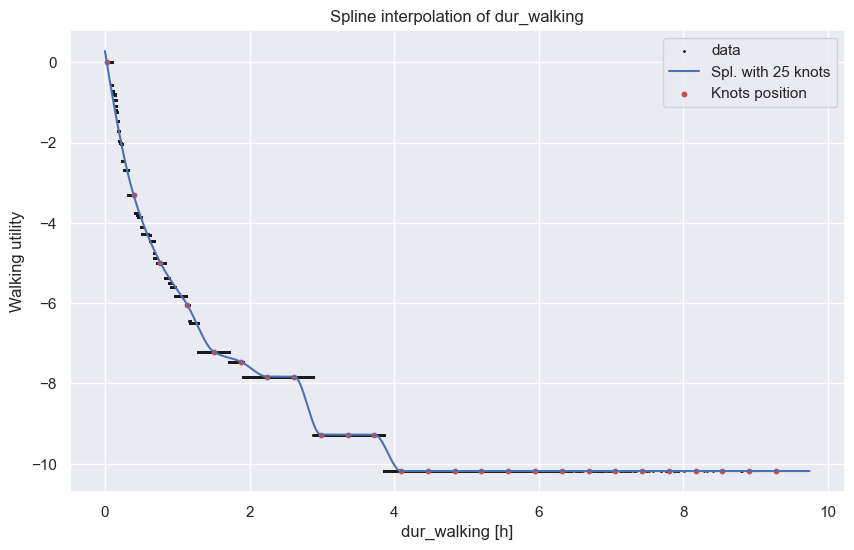

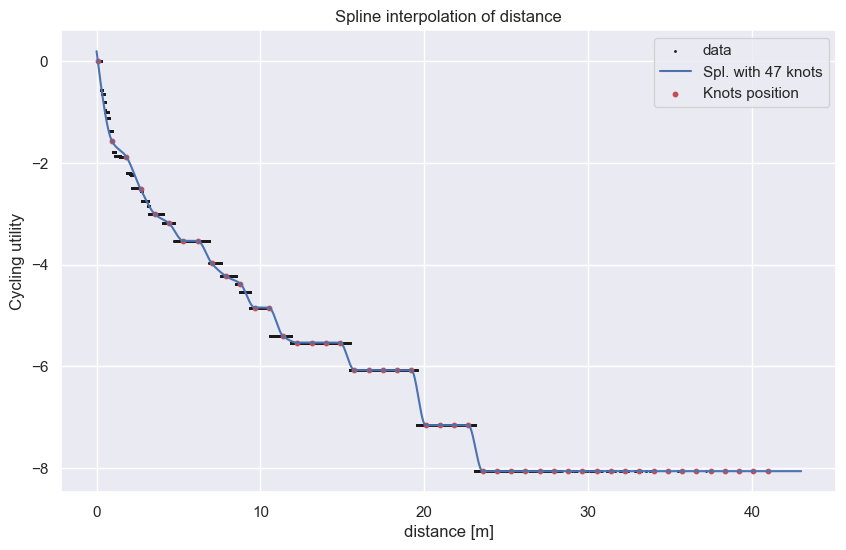

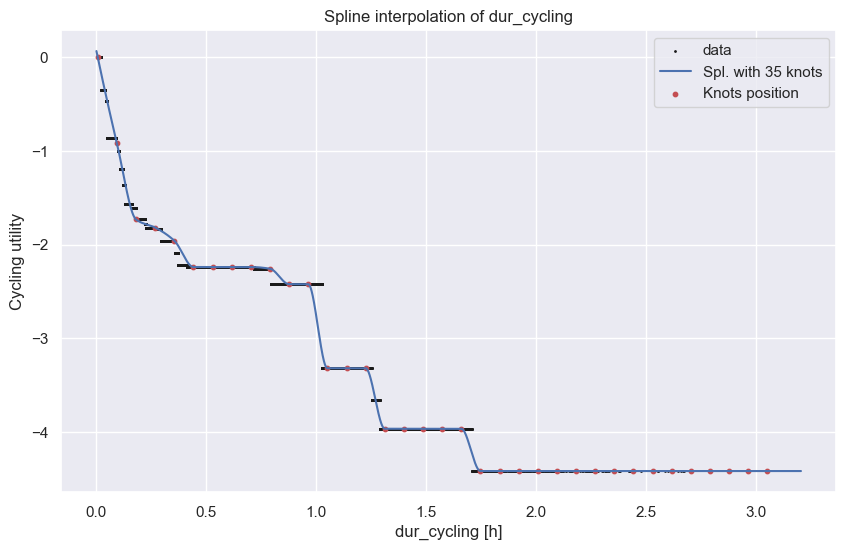

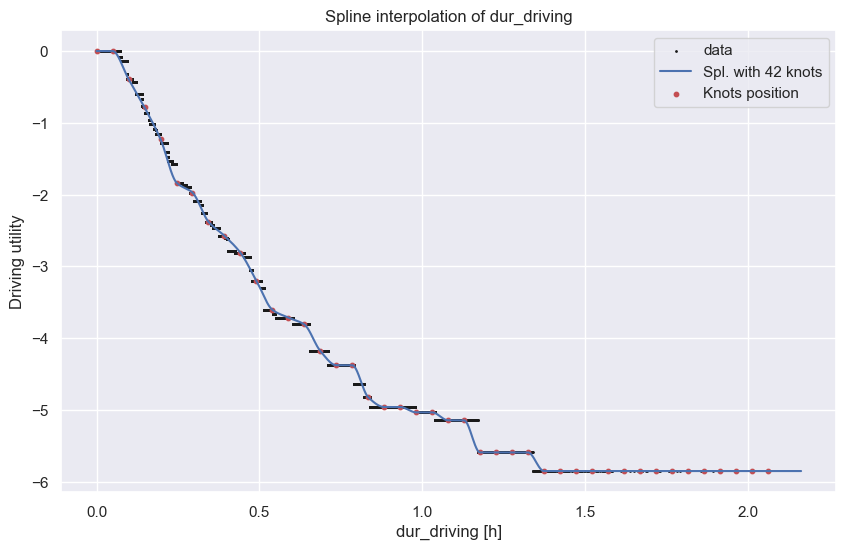

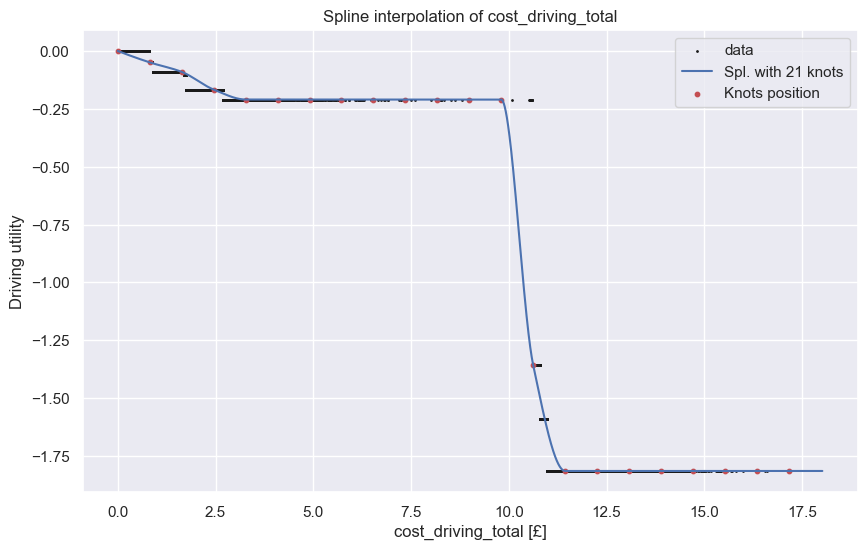

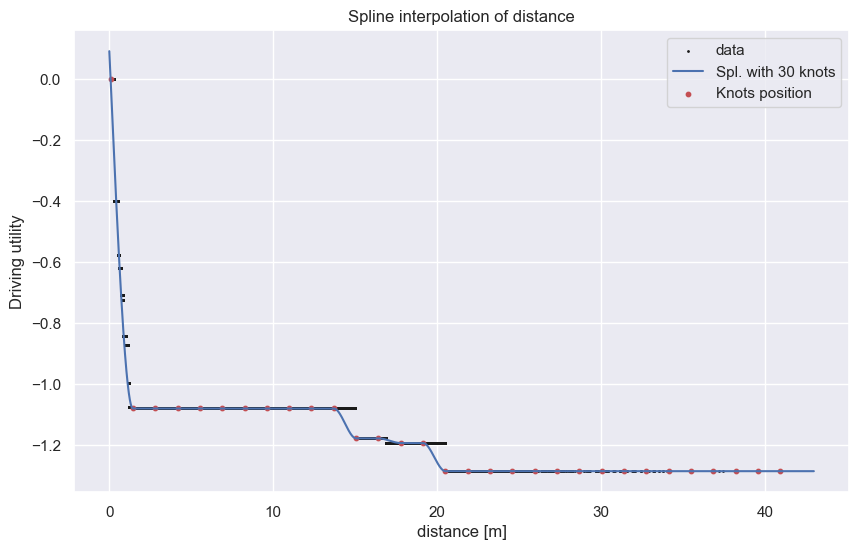

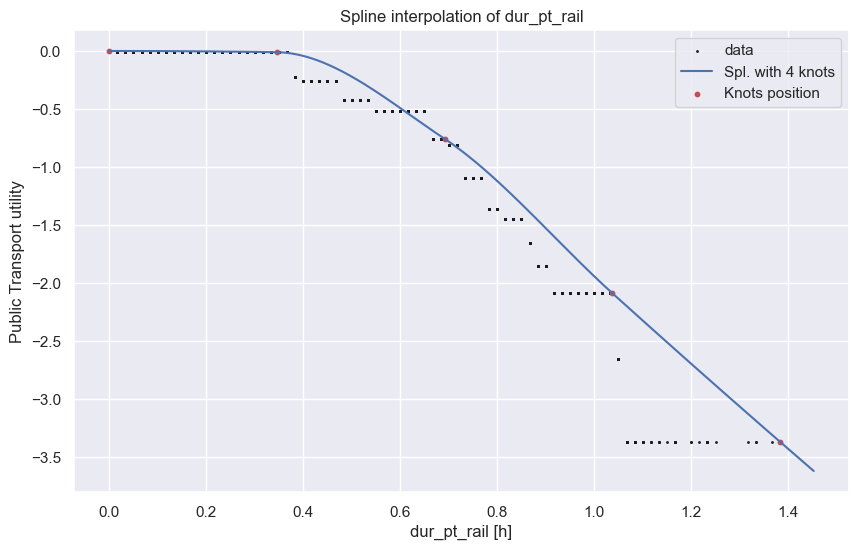

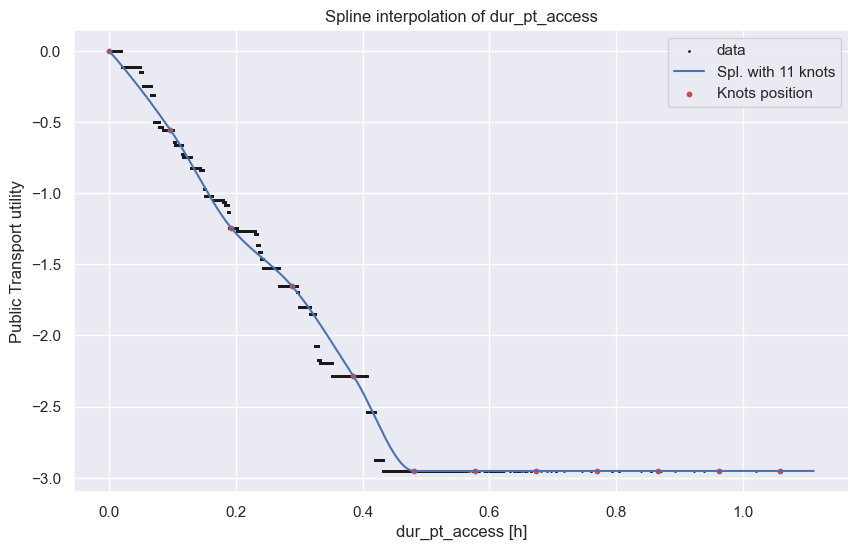

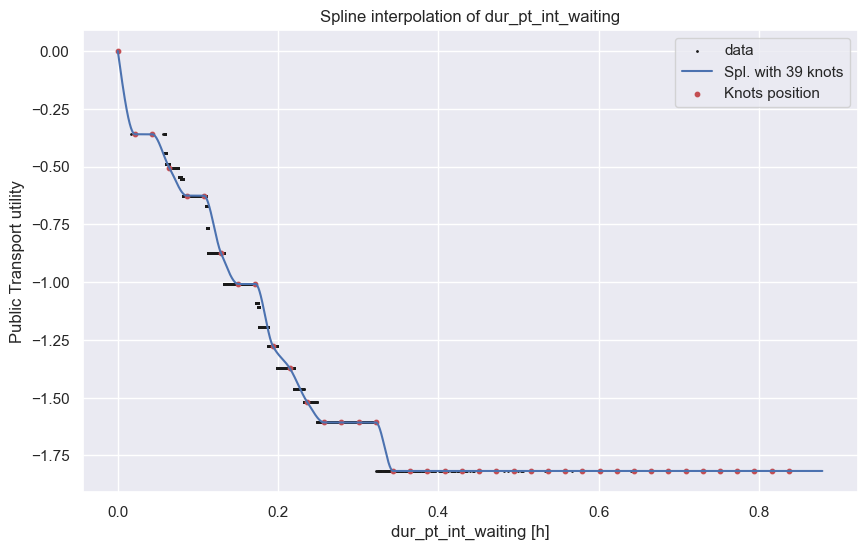

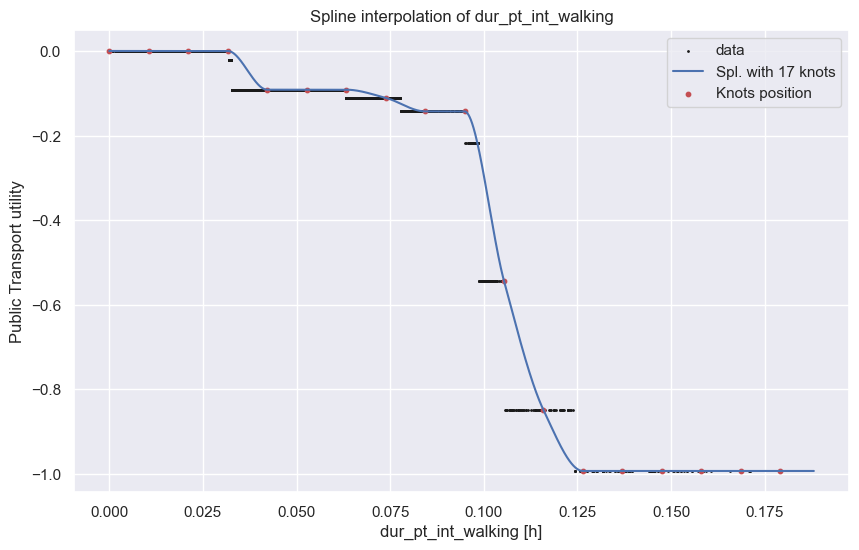

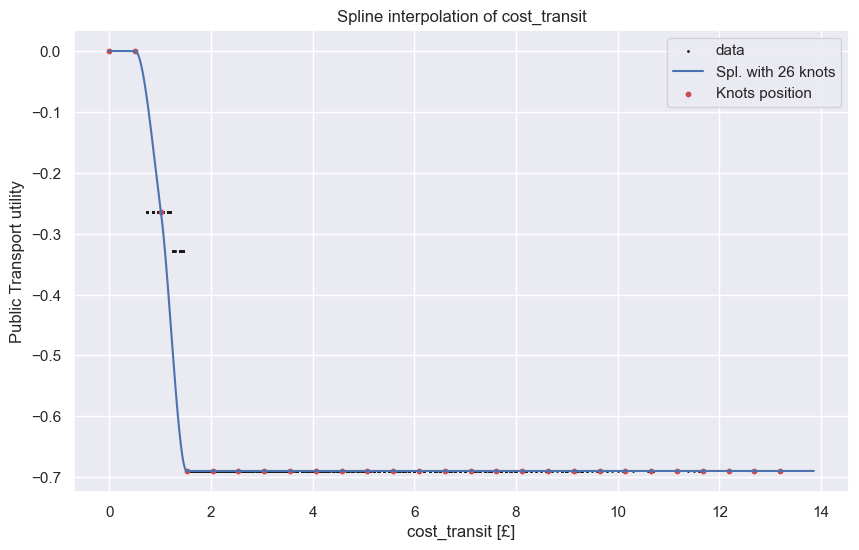

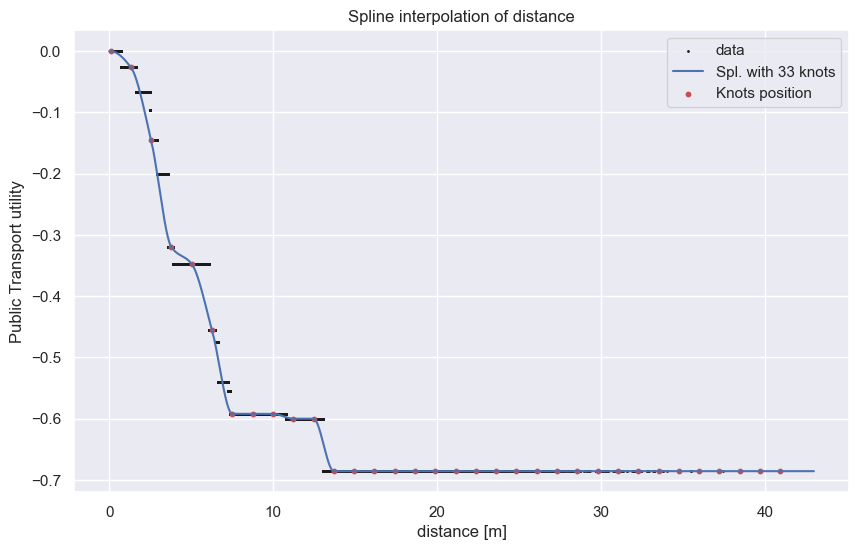

In [6]:
best_splines = {'0': {'dur_walking': 25}, '1': {'distance': 47, 'dur_cycling': 35}, '3': {'dur_driving': 42, 'cost_driving_total': 21, 'distance': 30}, '2': {'dur_pt_rail': 4, 'dur_pt_access': 11, 'dur_pt_int_waiting': 39, 'dur_pt_int_walking': 17, 'cost_transit': 26, 'distance': 33}}
plot_spline(LPMC_model_trained,LPMC_train,best_splines, utility_names)